# Machine Learning Group Assignment - Group G

The main goal for this assignment is to a build regression model in order to be able to predict the day - ahead price of power in Spain given some forecast available the daily auction.
As we have learned the power market is like many markets in which the price is settled where demand meets supply. In order to better understand this we will go more in depth by analysing the different production types there are in supply and as we will see along the anlysis we will also analyse the seasonality and temperature effects in the demand variables.
During this analysis we will go more in depth analysing the variables previously mentioned in order to be able to get the best possible model to accomplish the established goal of correctly predicting the day - ahead prices for power in Spain.

## Setup

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from datetime import date

The first step in order to get started with our project is to get ready and import all the correct packages we will use during the assignment, we prepared our setup. 
The next next step will be to read the our dataset.

In [2]:
df = pd.read_csv("power_market.csv", parse_dates=["date"])

df = df.rename(columns={"import_FR": "import_fr", "export_FR":"export_fr"})


init_df = df
df.head()

,fc_demand,fc_nuclear,import_fr,export_fr,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1
2,21893.0,7117.2,3000.0,2650.0,1823.0,0.0,4.6,51.95,2017-01-01,2
3,20693.0,7117.2,3000.0,2650.0,1777.0,0.0,9.7,47.27,2017-01-01,3
4,19599.0,7117.2,3000.0,2650.0,1746.0,0.0,24.1,45.49,2017-01-01,4


Once we read our dataset we decided to rename some of the columns in order to make it easier for us to work with the dataset.

## EDA
Analyze each timeseries by itself: look for outliers, NaNs, and see their distributions.
Look for skewed distributions and think if you can convert the values into categories

### General



```
# This is formatted as code
```

For this first part of the EDA we focused on getting to know better the data we will be working with. We started by checking some of the main concepts, such as the data types we will be working with, the amount of null values each column might have, as this is a very important thing to take into considerating when builidng the model. Outliers might have a big repercusion in the performance of our model.
We also got some statisitcs again to get more insight information about the data we are working with.

In [3]:
df.shape[0]

32135

In [4]:
# Check data types
df.dtypes

fc_demand             float64
fc_nuclear            float64
import_fr             float64
export_fr             float64
fc_wind               float64
fc_solar_pv           float64
fc_solar_th           float64
price                 float64
date           datetime64[ns]
hour                    int64
dtype: object

In [5]:
# Check number of null values in columns
df.isna().sum()

fc_demand       0
fc_nuclear      0
import_fr      13
export_fr      13
fc_wind         0
fc_solar_pv     0
fc_solar_th     0
price           0
date            0
hour            0
dtype: int64

In [6]:
# Get some stats
df.describe()

,fc_demand,fc_nuclear,import_fr,export_fr,fc_wind,fc_solar_pv,fc_solar_th,price,hour
count,32135.000000,32135.000000,32122.000000,32122.000000,32135.000000,32135.000000,32135.000000,32135.000000,32135.000000
mean,28475.593527,6421.333431,2445.285163,2217.864703,5627.214688,1100.253546,601.186600,48.440119,11.500296
std,4686.675600,862.355391,623.215136,550.563300,3266.961919,1512.531532,681.584906,14.842233,6.922199
min,16372.000000,3672.800000,700.000000,200.000000,139.000000,0.000000,0.000000,0.030000,0.000000
25%,24605.500000,6071.900000,2100.000000,1900.000000,3083.000000,0.000000,31.600000,39.770000,6.000000
50%,28446.000000,7117.200000,2450.000000,2200.000000,4989.000000,107.800000,331.400000,49.880000,12.000000
75%,32124.000000,7117.200000,2900.000000,2600.000000,7610.500000,2099.350000,957.150000,58.250000,17.500000
max,41103.000000,7117.200000,3700.000000,3700.000000,17232.000000,7211.200000,2253.700000,101.990000,23.000000


For the next part of the analysis we decided to go more in depth in how th power market really works, so as we know  this is like many markets and so price is settled where demand meets supply as we previously mentioned. Each type of production is different and so they should be analsyed independently before making any decision. We first analysed the supply so for this we mainly focused on power generation plants, specifically in: nuclear, wind and solar. For each one of them we did an individual analysis to get more in depth information. Then we did a similar analysis for demand and its specific variables. We know that for this type of market there is the human aspect to take into consideration and observe its specific behaviours, this behaviours are affected due to season and temperature. By making this assumption we decided to analyze seasonality to see the different distributions and the correlations there might be.

### Analyzing the Nuclear (fc_nuclear) column
fc nuclear: forecast of nuclear power production in MWh

In [7]:
df["fc_nuclear"].describe()

count    32135.000000
mean      6421.333431
std        862.355391
min       3672.800000
25%       6071.900000
50%       7117.200000
75%       7117.200000
max       7117.200000
Name: fc_nuclear, dtype: float64

#### Outliers

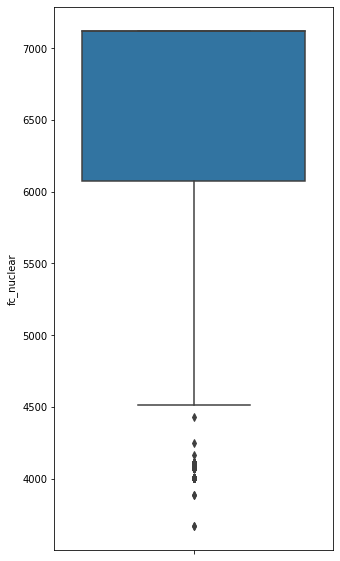

In [8]:
plt.figure(figsize=(5,10))
sns.boxplot(y="fc_nuclear", data=df)

In [9]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

In [10]:
df = remove_outlier(df, "fc_nuclear")

728 outliers removed


#### NAs

In [11]:
df["fc_nuclear"].isna().sum()

0

#### Distribution

Text(0.5, 1.0, 'nuclear power forecast distribution')

<Figure size 720x360 with 0 Axes>

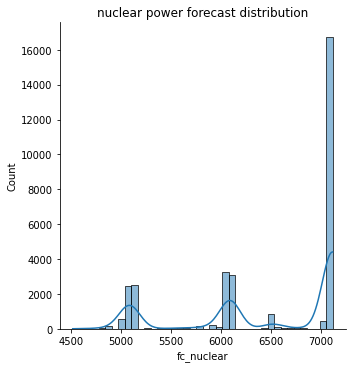

In [12]:
plt.figure(figsize=(10,5))
sns.displot(df["fc_nuclear"], kde=True)
plt.title("nuclear power forecast distribution")

### Analyzing the Wind (fc_wind) column
fc_wind: forecast of wind power production in MWh

In [13]:
df["fc_wind"].describe()

count    31407.000000
mean      5648.893591
std       3265.158479
min        139.000000
25%       3110.000000
50%       5020.000000
75%       7617.000000
max      17232.000000
Name: fc_wind, dtype: float64

#### Outliers

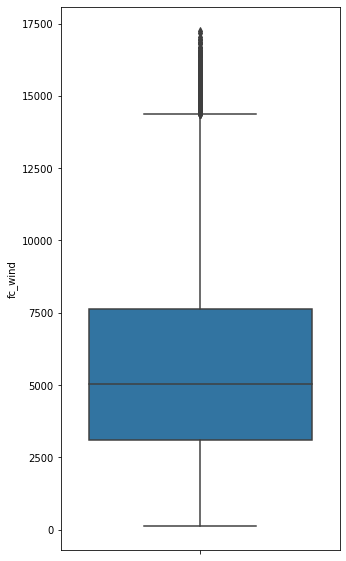

In [14]:
plt.figure(figsize=(5,10))
sns.boxplot(y="fc_wind", data=df,orient="v")

In [15]:
df = remove_outlier(df, "fc_wind")

360 outliers removed


#### NAs

In [16]:
df["fc_wind"].isna().sum()

0

#### Distribution

Text(0.5, 1.0, 'Wind power forecast distribution')

<Figure size 720x360 with 0 Axes>

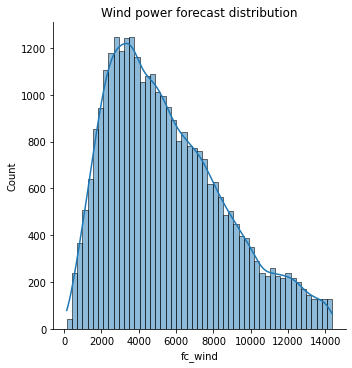

In [17]:
plt.figure(figsize=(10,5))
sns.displot(df["fc_wind"], kde=True)
plt.title("Wind power forecast distribution")

### Analyzing the PV Solar (fc_solar_pv) column
fc_solar_pv: forecast of PV solar (solar panels) power production in MWh

In [18]:
df["fc_solar_pv"].describe()

count    31047.000000
mean      1084.603849
std       1490.934621
min          0.000000
25%          0.000000
50%         99.100000
75%       2080.250000
max       7211.200000
Name: fc_solar_pv, dtype: float64

#### Outliers

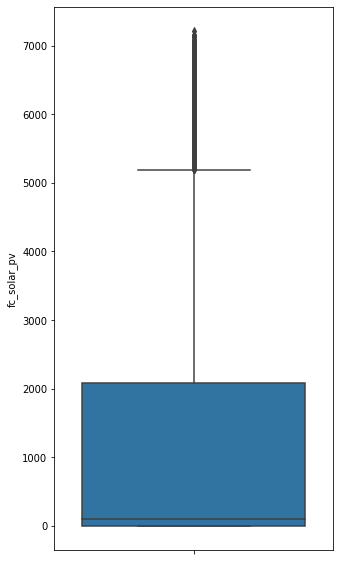

In [19]:
plt.figure(figsize=(5,10))
sns.boxplot(y="fc_solar_pv", data=df,orient="v")

In [20]:
df = remove_outlier(df, "fc_solar_pv")

761 outliers removed


#### NAs

In [21]:
df["fc_solar_pv"].isna().sum()

0

#### Distribution

Text(0.5, 1.0, 'Solar power forecast distribution')

<Figure size 720x360 with 0 Axes>

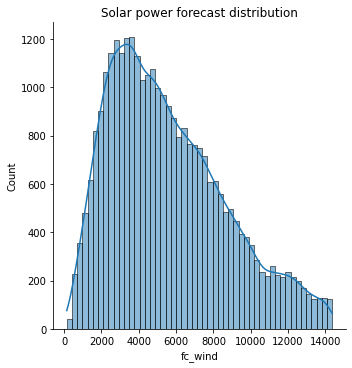

In [22]:
plt.figure(figsize=(10,5))
sns.displot(df["fc_wind"],kde=True)
plt.title("Solar power forecast distribution")

### Analyzing the termal solar (fc_solar_th) column
fc_solar_th: forecast of thermal solar power production in MWh

In [23]:
df["fc_solar_th"].describe()

count    30286.000000
mean       570.727732
std        659.481523
min          0.000000
25%         29.300000
50%        308.850000
75%        870.525000
max       2253.700000
Name: fc_solar_th, dtype: float64

#### Outliers

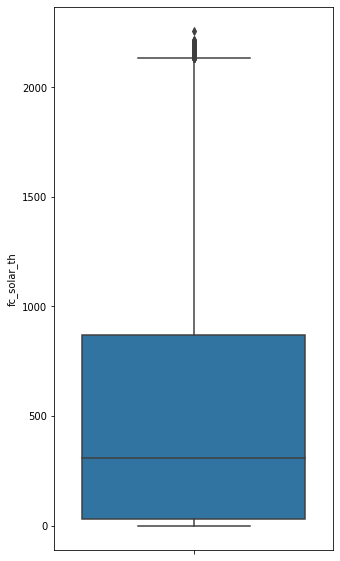

In [24]:
plt.figure(figsize=(5,10))
sns.boxplot(y="fc_solar_th", data=df,orient="v")

In [25]:
df = remove_outlier(df, "fc_solar_th")

340 outliers removed


#### NAs

In [26]:
df["fc_solar_th"].isna().sum()

0

#### Distribution

Text(0.5, 1.0, 'Thermal solar power forecast distribution')

<Figure size 720x360 with 0 Axes>

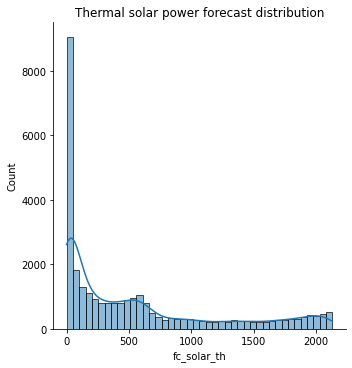

In [27]:
plt.figure(figsize=(10,5))
sns.displot(df["fc_solar_th"], kde=True)
plt.title("Thermal solar power forecast distribution")

### Analyzing the demand (fc_demand) column
fc_demand: forecast of demand in MWh

In [28]:
df["fc_demand"].describe()

count    29946.000000
mean     28409.191979
std       4688.530705
min      16372.000000
25%      24533.000000
50%      28349.500000
75%      32049.750000
max      41103.000000
Name: fc_demand, dtype: float64

#### Outliers

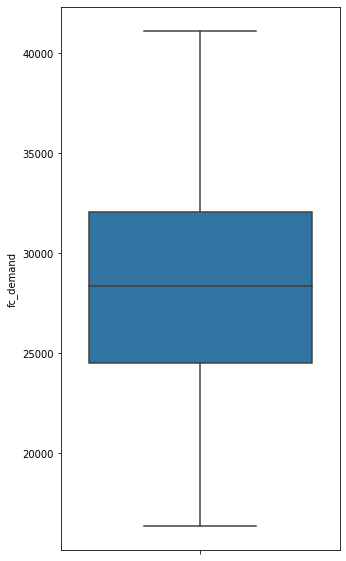

In [29]:
plt.figure(figsize=(5,10))
sns.boxplot(y="fc_demand", data=df,orient="v")

In [30]:
df = remove_outlier(df, "fc_demand")

0 outliers removed


#### NAs

In [31]:
df["fc_demand"].isna().sum()

0

#### Distribution

Text(0.5, 1.0, 'Demand forecast distribution')

<Figure size 720x360 with 0 Axes>

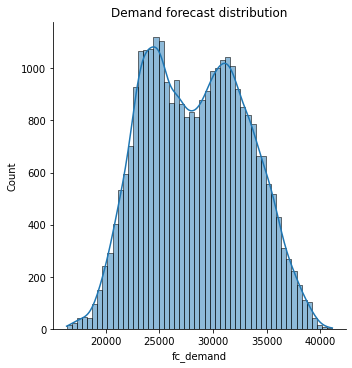

In [32]:
plt.figure(figsize=(10,5))
sns.displot(df["fc_demand"],kde=True)
plt.title("Demand forecast distribution")

### Analyzing the demand (fc_demand) column
fc_demand: forecast of demand in MWh

In [33]:
df["fc_demand"].describe()

count    29946.000000
mean     28409.191979
std       4688.530705
min      16372.000000
25%      24533.000000
50%      28349.500000
75%      32049.750000
max      41103.000000
Name: fc_demand, dtype: float64

#### Outliers

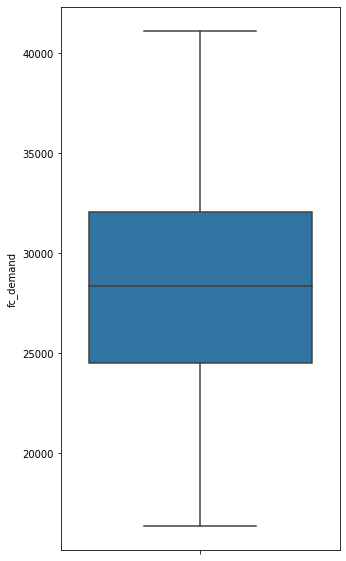

In [34]:
plt.figure(figsize=(5,10))
sns.boxplot(y="fc_demand", data=df,orient="v")

In [35]:
df = remove_outlier(df, "fc_demand")

0 outliers removed


#### NAs

In [36]:
df["fc_demand"].isna().sum()

0

#### Distribution

Text(0.5, 1.0, 'Demand forecast distribution')

<Figure size 720x360 with 0 Axes>

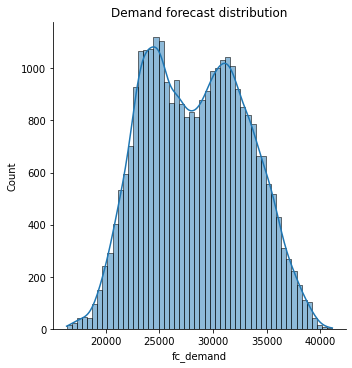

In [37]:
plt.figure(figsize=(10,5))
sns.displot(df["fc_demand"], kde=True)
plt.title("Demand forecast distribution")

### Analyzing the demand (import_FR) column
import_FR: forecast of the importing capacity from France to Spain in MWh

In [38]:
df["import_fr"].describe()

count    29933.000000
mean      2452.726088
std        628.788599
min        700.000000
25%       2100.000000
50%       2500.000000
75%       2900.000000
max       3700.000000
Name: import_fr, dtype: float64

#### Outliers

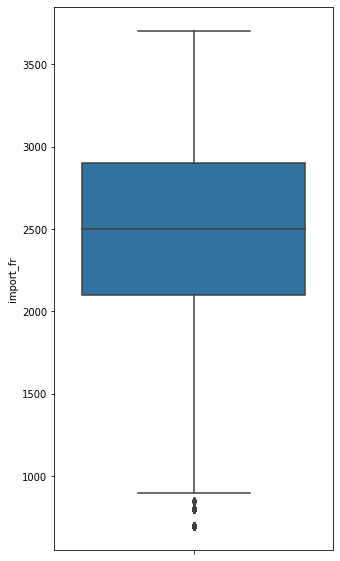

In [39]:
plt.figure(figsize=(5,10))
sns.boxplot(y="import_fr", data=df,orient="v")

In [40]:
df = remove_outlier(df, "import_fr")

304 outliers removed


#### NAs

In [41]:
df["import_fr"].isna().sum()

0

#### Distribution

Text(0.5, 1.0, 'Demand forecast distribution')

<Figure size 720x360 with 0 Axes>

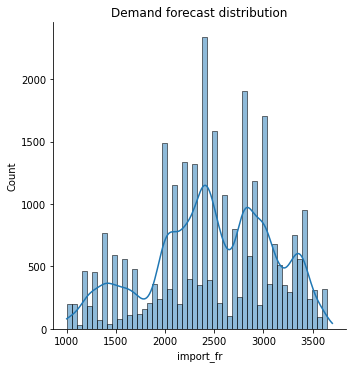

In [42]:
plt.figure(figsize=(10,5))
sns.displot(df["import_fr"], kde=True)
plt.title("Demand forecast distribution")

### Analyzing the demand (export_fr) column
export_FR: forecast of the exporting capacity from Spain to France in MWh

In [43]:
df["export_fr"].describe()

count    29642.000000
mean      2234.437622
std        550.529067
min        200.000000
25%       1900.000000
50%       2250.000000
75%       2600.000000
max       3700.000000
Name: export_fr, dtype: float64

#### Outliers

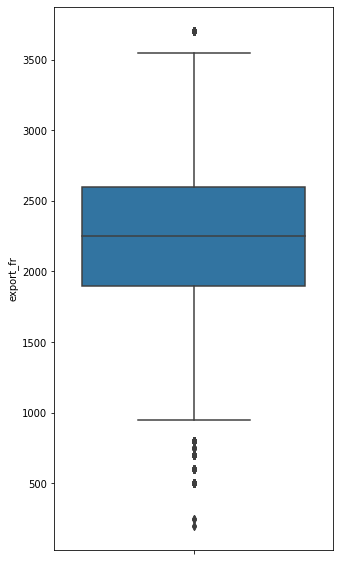

In [44]:
plt.figure(figsize=(5,10))
sns.boxplot(y="export_fr", data=df,orient="v")

In [45]:
df = remove_outlier(df, "export_fr")

429 outliers removed


#### NAs

In [46]:
df["export_fr"].isna().sum()

0

#### Distribution

Text(0.5, 1.0, 'Demand forecast distribution')

<Figure size 720x360 with 0 Axes>

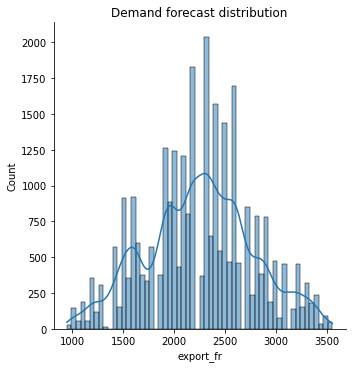

In [47]:
plt.figure(figsize=(10,5))
sns.displot(df["export_fr"], kde=True )
plt.title("Demand forecast distribution")

### Analyzing the Hour (hour) column

In [48]:
df["hour"].describe()

count    29213.000000
mean        11.375312
std          7.047007
min          0.000000
25%          5.000000
50%         11.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64

#### Outliers

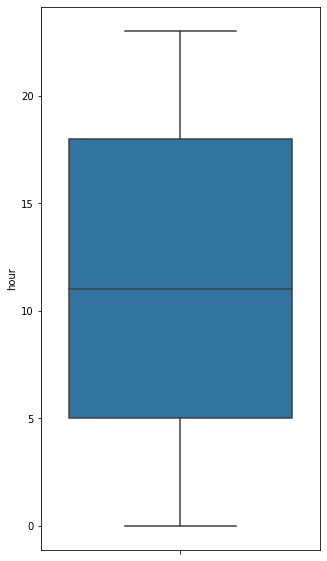

In [49]:
plt.figure(figsize=(5,10))
sns.boxplot(y="hour", data=df,orient="v")


#### NAs

In [50]:
df["hour"].isna().sum()

0

#### Distribution

Text(0.5, 1.0, 'hour per day distribution')

<Figure size 720x360 with 0 Axes>

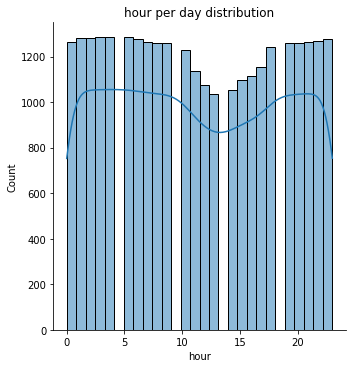

In [51]:

plt.figure(figsize=(10,5))
sns.displot(df["hour"], kde=True)
plt.title("hour per day distribution")

In [52]:
df["hour"].value_counts()

4     1286
5     1285
3     1284
2     1283
1     1282
6     1278
23    1276
22    1267
7     1266
21    1265
0     1263
8     1261
9     1259
20    1258
19    1258
18    1242
10    1228
17    1155
11    1138
16    1117
15    1096
12    1074
14    1055
13    1037
Name: hour, dtype: int64

In [53]:
# Check if each day has 24 hours

df_ob_date = df[["hour","date"]].groupby(["date"], as_index=False).count().sort_values(by=["hour"])
df_ob_date

,date,hour
1033,2019-11-13,1
513,2018-06-05,2
745,2019-01-23,2
1219,2020-05-18,3
630,2018-09-30,3
...,...,...
493,2018-05-11,24
655,2018-10-25,24
299,2017-10-29,25
1020,2019-10-27,25


In [54]:
# Check 
df_ob_date["hour"].value_counts()

24    961
23     53
17     44
16     41
19     34
22     33
18     32
20     28
21     20
8      14
7       8
12      7
15      6
5       6
6       5
3       3
25      3
13      3
9       2
11      2
2       2
10      1
4       1
14      1
1       1
Name: hour, dtype: int64

### Analyzing the Date (date) column

In [55]:
stats_date = df["date"].describe(datetime_is_numeric=True)
stats_date

count                            29213
mean     2018-10-14 19:28:00.032850176
min                2017-01-01 00:00:00
25%                2017-11-29 00:00:00
50%                2018-10-16 00:00:00
75%                2019-08-30 00:00:00
max                2020-08-31 00:00:00
Name: date, dtype: object

#### Outliers

#### NAs

In [56]:
df["date"].isna().sum()

0

#### Distribution

In [57]:
# Get first 
df["date"].iloc[[0]]

0   2017-01-01
Name: date, dtype: datetime64[ns]

In [58]:
# Get last 
df["date"].iloc[[-1]]

32134   2020-08-31
Name: date, dtype: datetime64[ns]

In [59]:
# Check if dates are missing
from datetime import date, timedelta

first_day = stats_date["min"]
last_day = stats_date ["max"]

date_set = set(df["date"][1] + timedelta(x) for x in range((df["date"][17379] - df["date"][1]).days))
missing = sorted(date_set - set(df["date"]))
missing

[Timestamp('2017-06-02 00:00:00'),
 Timestamp('2017-06-03 00:00:00'),
 Timestamp('2018-05-28 00:00:00'),
 Timestamp('2018-05-29 00:00:00'),
 Timestamp('2018-05-30 00:00:00'),
 Timestamp('2018-05-31 00:00:00'),
 Timestamp('2018-06-01 00:00:00')]

### Feature Creation
Feature Engineering is one of the most important steps of the process for developing prediciton models. It might be considered as an art as it involves human design and some intuition. For our dataset we are using Power_market.csv. This dataset includes different variable types such as float64, datatime64, object, bool and int64. 
For the Pre-Feature Engineering part we decided that we should see how price and demand are affected with: seasons, holidays and workingdays.


#### Extract year, month, day
In order to be able to see this we first had to extract year, month, day and and the weekdays from the original dataset in order to be able to later observe the seasonalities and see the realtionships there might be.

In [60]:
def extract_ymd(df):
    df["year"]= df.date.dt.year
    df["month"]=df.date.dt.month
    df["day"]=df.date.dt.day
    df["weekday"]=df.date.dt.weekday
    
    return df

#### Create season column
- 1 = spring
- 2 = summer 
- 3 = fall 
- 4 = winter


https://www.timeanddate.com/calendar/aboutseasons.html

Once year, month, day and the weekday where extracted we decided to create a season column in order to be able to study and observe the different relationships there are. To create this season column we had to first import datetime as date, then we defined the season function and specified the list with the specified dates and then create the loop to make sure we have all elements in the season. We also decided to create some new columns in order to be able to better work with the data we have, the columns that we decided that could be useful are the following: holiday column and workingday column. This will allow us to see the different relationships they might have with demand and supply.
To be able to do this we took some inspiration from an exercise we found in your github profile, and we adapted it to our dataset.

In [61]:
from datetime import date

def get_season(date_to_convert):  # the function expects a datetime.date object as input
    
    # fix the year of the input
    date_year = date_to_convert.year
    
    # create the list of tuples on which to loop
    seasons = [
        ("winter", date(date_year, 12, 21), date(date_year, 12, 31)),
        ("spring", date(date_year, 3, 20), date(date_year, 6, 21)),
        ("summer", date(date_year, 6, 22), date(date_year, 9, 21)),
        ("fall", date(date_year, 9, 22), date(date_year, 12, 20)),
        ("winter", date(date_year, 1, 1), date(date_year, 3, 19))
    ]
    
    # loop for each season trying to find the season to which
    # date_to_convert belongs to
    for elem in seasons:  # season = tuple(name, start, end) = (elem[0], elem[1], elem[2])
        if date_to_convert>=elem[1] and date_to_convert<=elem[2]:  
            return elem[0]

#### Create a holiday column

In [62]:
def extract_holiday(df):
    cal = calendar()
    holidays = cal.holidays(start=df["date"].min(), end=df["date"].max())
    df["holiday"] = np.where(df["date"].isin(holidays),True,False) 
    
    return df

#### Create a workingday column

In [63]:
def extract_working_day(df):
    df["workingday"] = np.where(df["weekday"] < 5,True,False)
    
    return df

#### Create difference demand vs. supply

In [64]:
def extract_demand_vs_supply(df):
    production_features = ["fc_nuclear", "import_fr", "fc_wind", "fc_solar_pv","fc_solar_th"]
    # The available supply in Spain
    df["fc_production"] = df[production_features].sum(axis=1)-df["export_fr"]
    # The gap between demand and supply
    df["fc_delta"] = df["fc_demand"] - df["fc_production"]
    
    return df

#### Create  usage ratio

In [65]:
def extract_usage_ratios(df):
    production_features = ["fc_nuclear", "import_fr", "fc_wind", "fc_solar_pv","fc_solar_th"]
    # The proportionate ratio of the total demand
    for prod_type in production_features:
        df[f"ratio_{prod_type}_demand"] = df[prod_type] / df["fc_demand"]
    
    # proportionate ratio of the total demand
    df["ratio_export_fr_demand"] = df["export_fr"] / df["fc_demand"]
    
    # Total ratio of production / demand
    df["ratio_production_demand"] = df["fc_production"] / df["fc_demand"]
    
    # The effect of renewables
    df["ratio_renewables"] = (df["fc_wind"] + df["fc_solar_pv"] + df["fc_solar_th"]) / df["fc_demand"] 
    
    return df

#### Create thermal gap 

In [66]:
def extract_thermal_gap(df):
    df["thermal_gap"] = (
        df["fc_demand"] 
        - df["fc_wind"] 
        - df["fc_solar_pv"] - df["fc_solar_th"]
        - df["fc_nuclear"])
    
    return df

#### Consolidate all creation functions

In [67]:
# This function consolidates all feature creation steps
def transform(df):
    # Create year, month, day, column
    df = extract_ymd(df)
    
    # Create season column
    df["season"] = df["date"].map(get_season)
    
    # Create holiday column
    df = extract_holiday(df)
    
    # Create workingday column
    df["workingday"] = np.where(df["weekday"] < 5,True,False)
    
    # Create demand vs. supply columns
    df = extract_demand_vs_supply(df)
    
    # demand related ratios
    df = extract_usage_ratios(df)
    
    # Create thermal gap column
    df = extract_thermal_gap(df)
    
    return df

In [68]:
df = transform(df).dropna()

## EDA Target

### Price analyis

#### Outliers

Text(0.5, 1.0, 'price boxplot')

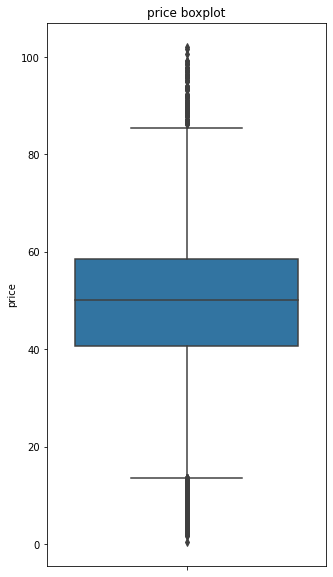

In [69]:
plt.figure(figsize=(5,10))
sns.boxplot(data=df,y="price",orient="v")
plt.title("price boxplot")

#### Distribution

Text(0.5, 1.0, 'price distribution')

<Figure size 720x360 with 0 Axes>

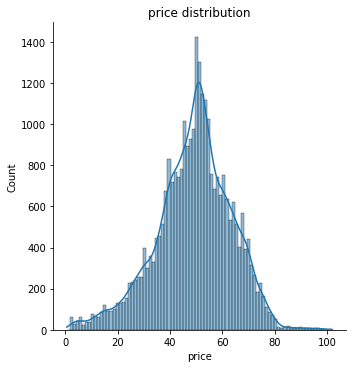

In [70]:
plt.figure(figsize=(10,5))
sns.displot(df["price"], kde=True)
plt.title("price distribution")

In [71]:
# TODO describe so what. transform?

### Time related analsysis

For the time related analysis we decided to start detecting the different oultiers we could find per season and then started to see the different relationships between the different variables. We started by plotting the price per hour and price and workingday to see the relationships or trends there might be. We started having an overview and then we will go more in depth withe the rest of variables and columns we created.


#### Outliers

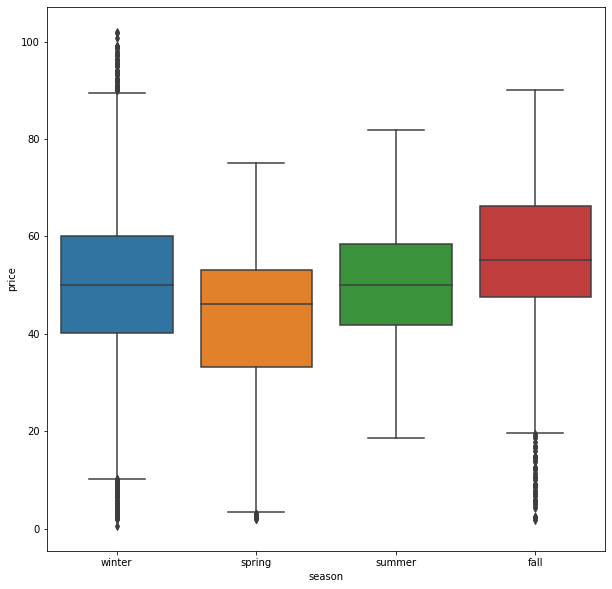

In [72]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df,y="price",x="season",orient="v")

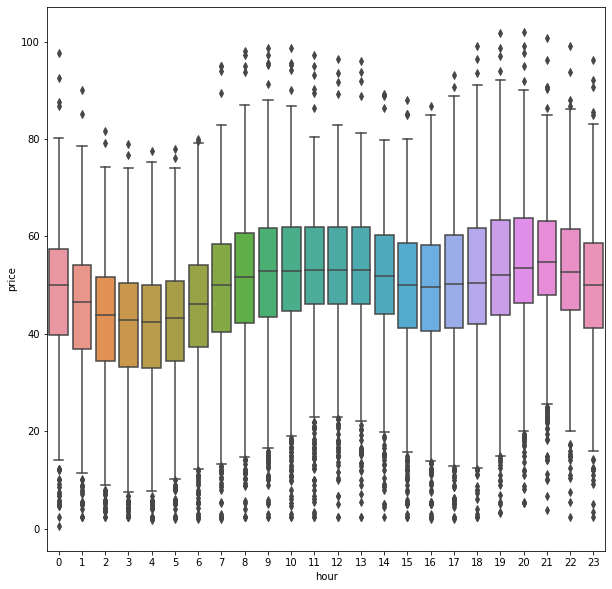

In [73]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df,y="price",x="hour",orient="v")

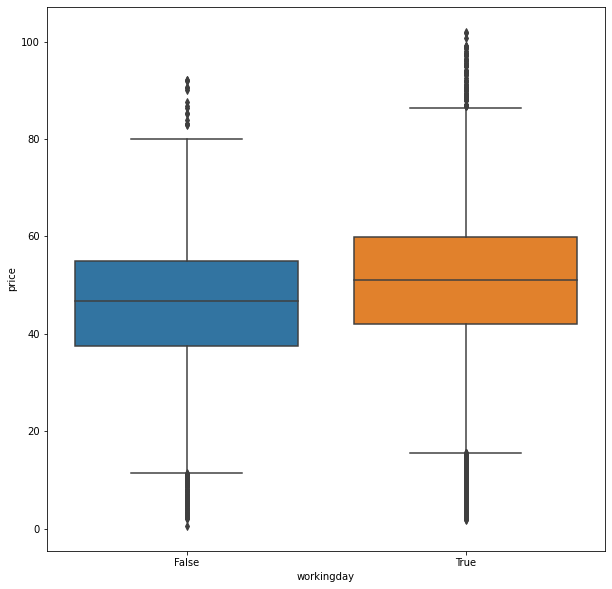

In [74]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df,y="price",x="workingday",orient="v")

Text(0.5, 1.0, 'price vs year')

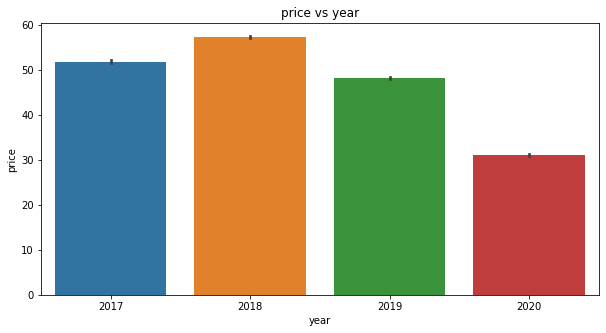

In [75]:
plt.figure(figsize=(10,5))
sns.barplot(x="year",y="price",data=df)
plt.title("price vs year")

Text(0.5, 1.0, 'price vs month')

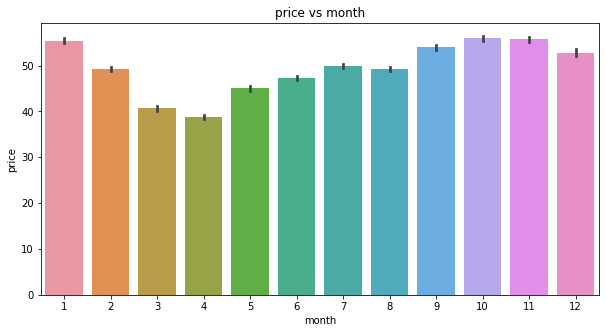

In [76]:
plt.figure(figsize=(10,5))
sns.barplot(x="month",y="price",data=df)
plt.title("price vs month")

Text(0.5, 1.0, 'hours vs weekday')

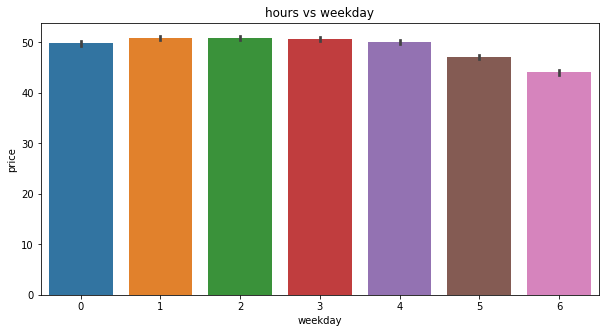

In [77]:
plt.figure(figsize=(10,5))
sns.barplot(x="weekday",y="price",data=df)
plt.title("hours vs weekday")

Text(0.5, 1.0, 'working day vs price')

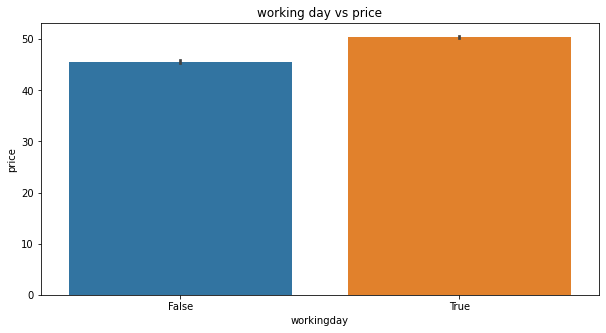

In [78]:
plt.figure(figsize=(10,5))
sns.barplot(x="workingday",y="price",data=df)
plt.title("working day vs price")

Text(0.5, 1.0, 'hours vs price')

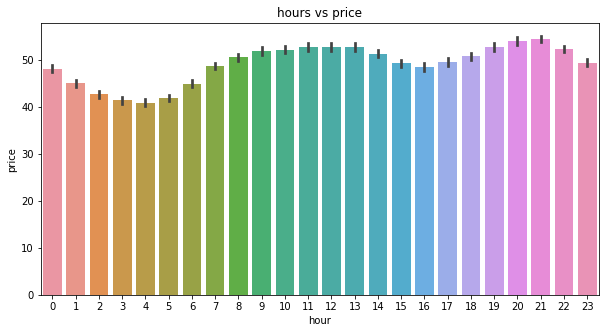

In [79]:
plt.figure(figsize=(10,5))
sns.barplot(x="hour",y="price",data=df)
plt.title("hours vs price")

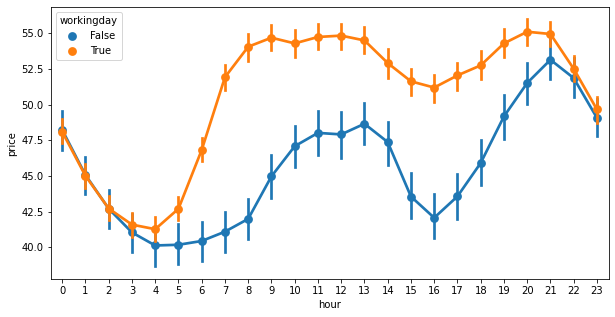

In [80]:
plt.figure(figsize=(10,5))
sns.pointplot(x="hour", y="price", data=df, hue="workingday")

No handles with labels found to put in legend.


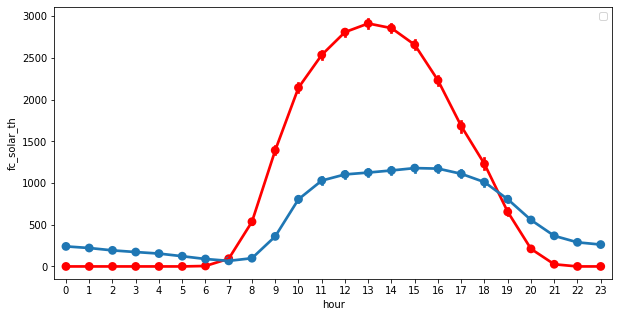

In [81]:
plt.figure(figsize=(10,5))
sns.pointplot(x="hour", y="fc_solar_pv", data=df, color="red", label="A")
sns.pointplot(x="hour", y="fc_solar_th", data=df)
plt.legend()

For the 2 graphs at the top we decided to focus on plotting the relationship that price and hour have during working and non working days in order to see the differences there might be, as we can see prices are higher on workingdays than in non working ones. 
For the second graph we decisded to plot fc_solar_pv and fc_solar_th, to see if they have a relationship or not. What we can appreciate is that they might have some relatinship as we see that they mainly follow the same patterns according to the graph and it also makes sense that during the middle of the day we see the highest amount of sun and the highest temperature.

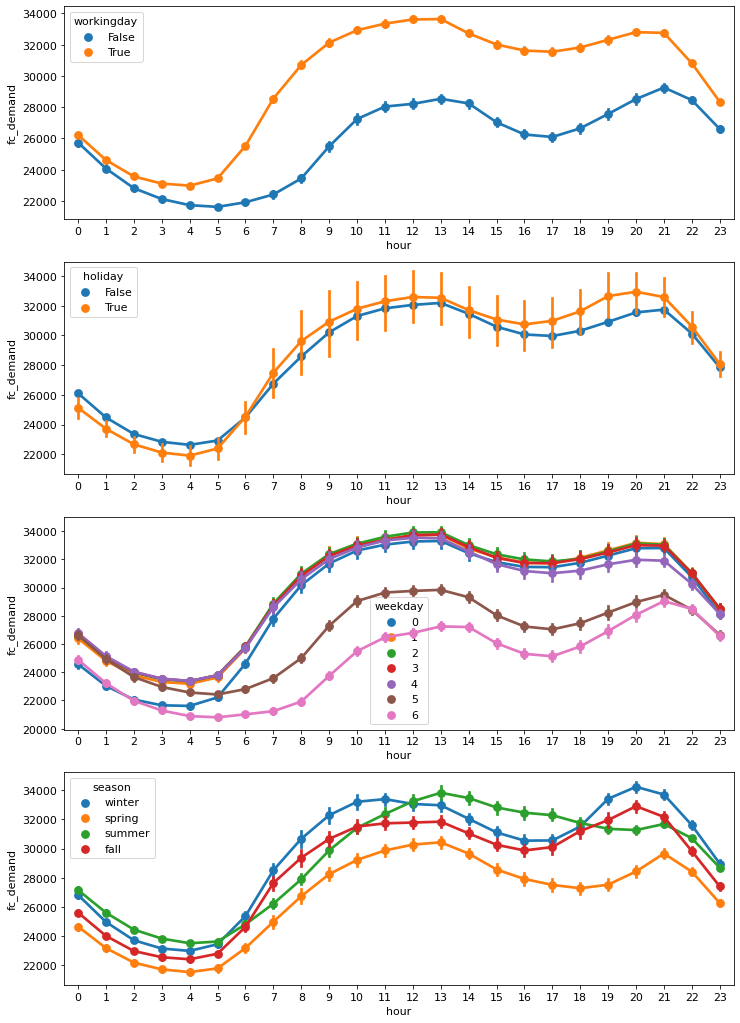

In [82]:
# Step 1 : Prepare m rows n columns Figure
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=4)
figure.set_size_inches(12, 18)

# Step 2 : Assign subplot
# Pointplot of the average demand per hours by workingday, holiday, weekday, season, weather
sns.pointplot(x='hour', y='fc_demand', data=df, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='fc_demand', data=df, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='fc_demand', data=df, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='fc_demand', data=df, hue='season', ax=axes[3])


For this set of graphs we wanted to analyse fc_demand with different variables in order to see its evolution through them, we started with working or non workingdays, for this we saw the same as in the previous graph we see that there is less demand during the non working days than during the working ones, this is proven througout the rest of the graphs. We also decided to create a new column with holidays in to see how this would be affected and we saw that actually in holidays there is more demand than in normal days. For the third graph we continue with the previous observation that on working days there is much more demand than on holidays, but we can also appreciate that there is also some difference between saturday and sundays demand, as we can appreciate on sundays is where we find with the less demand during the 7 days.
Finally it made sense to observe the demand for each of the seasons, we observe that the season with the lowest demand is spring, this makes sense due to the temperatures we find in this specific season, which allows the consumers to have less energy demand.

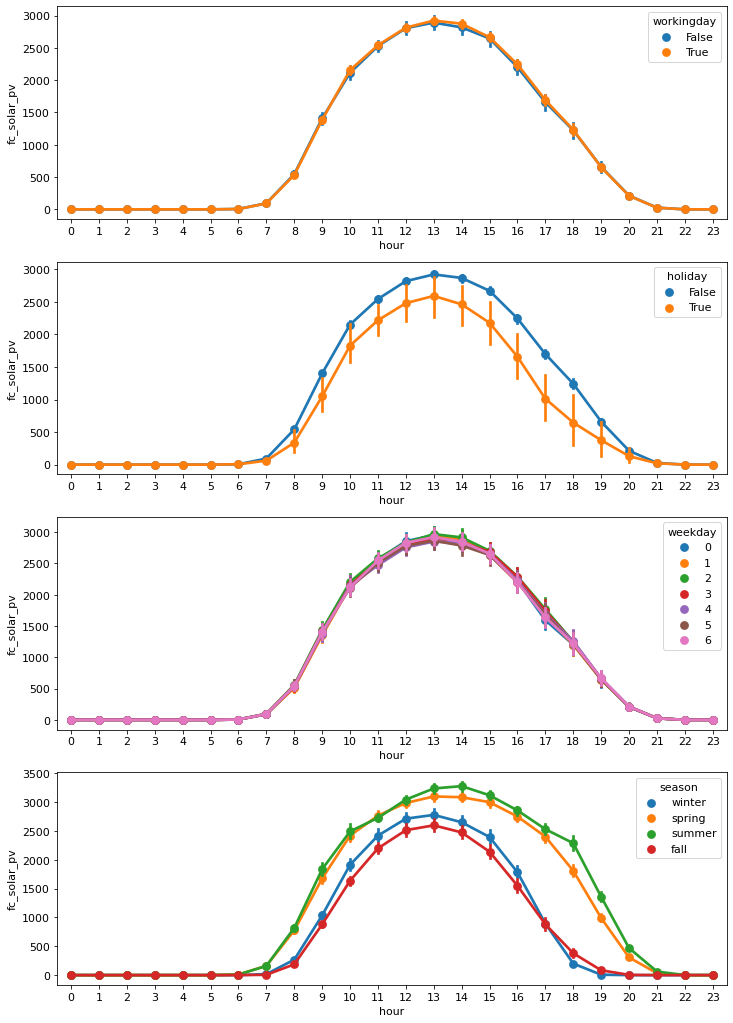

In [83]:
# Step 1 : Prepare m rows n columns Figure
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=4)
figure.set_size_inches(12, 18)

# Step 2 : Assign subplot
# Pointplot of the average Solar Panerls per hours by workingday, holiday, weekday, season, weather
sns.pointplot(x='hour', y='fc_solar_pv', data=df, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='fc_solar_pv', data=df, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='fc_solar_pv', data=df, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='fc_solar_pv', data=df, hue='season', ax=axes[3])

As a continuation of our analysis we analyzed how fc_solar_pv (forecast of PV solar power production for solar panels) and hour would be represented, in order to do so we ploted this set of graphs, we can appreciate that for the last graph which is comparing this forecast with the seasons, as we would expect the seasons with the biggest fc_solar_pv forecast are summer and spring, as they normally are the seasons with the highest solar activity.

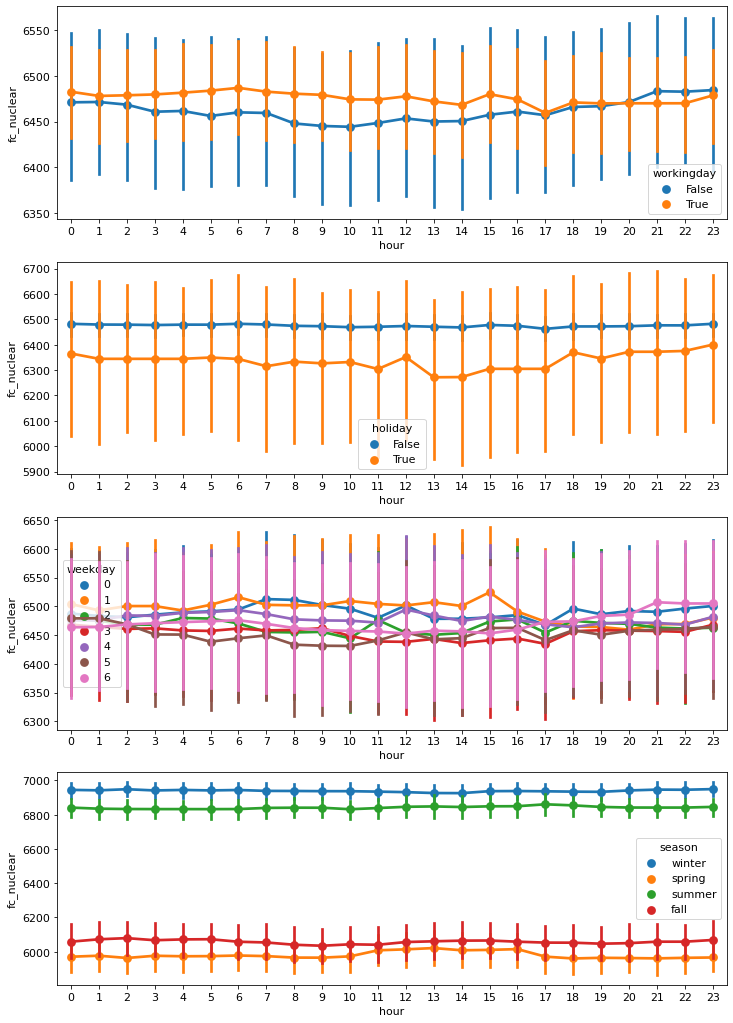

In [84]:
# Step 1 : Prepare m rows n columns Figure
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=4)
figure.set_size_inches(12, 18)

# Step 2 : Assign subplot
# Pointplot of the average Solar Panerls per hours by workingday, holiday, weekday, season, weather
sns.pointplot(x='hour', y='fc_nuclear', data=df, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='fc_nuclear', data=df, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='fc_nuclear', data=df, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='fc_nuclear', data=df, hue='season', ax=axes[3])

When comparing the nuclear power supply with the hours, we can see that it is only affected by season. We can clearly see that overall the supply is constant, but during winter and summer it is high.

### EDA Supply and demand

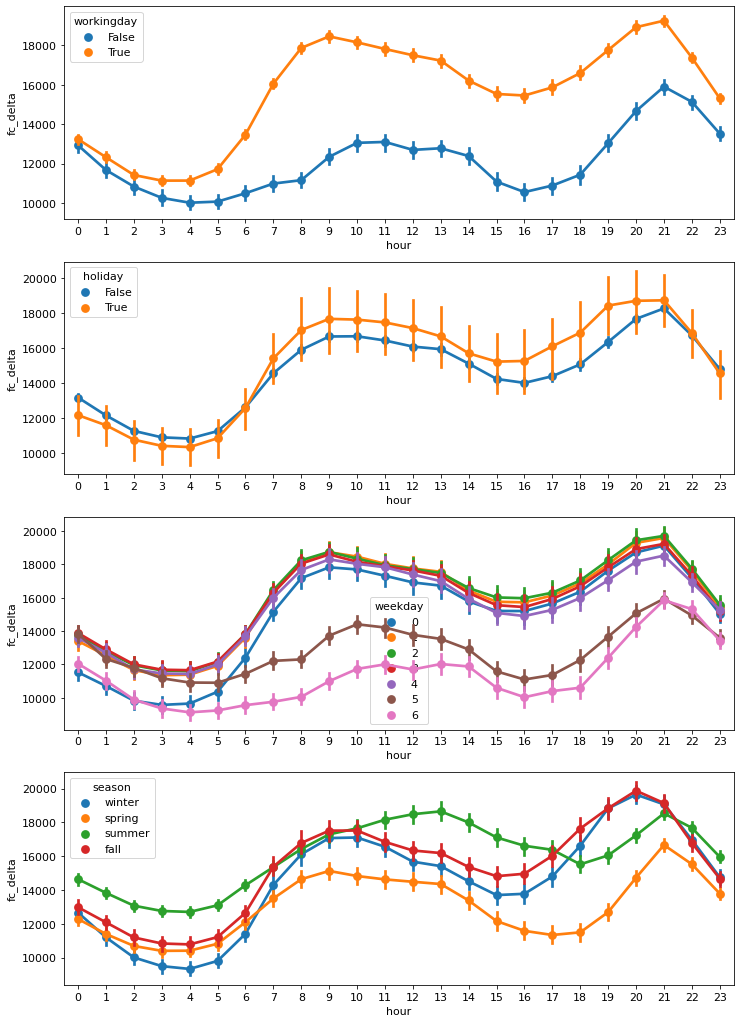

In [85]:
# Step 1 : Prepare m rows n columns Figure
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=4)
figure.set_size_inches(12, 18)

# Step 2 : Assign subplot
# Pointplot of the average demand per hours by workingday, holiday, weekday, season, weather
sns.pointplot(x='hour', y='fc_delta', data=df, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='fc_delta', data=df, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='fc_delta', data=df, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='fc_delta', data=df, hue='season', ax=axes[3])


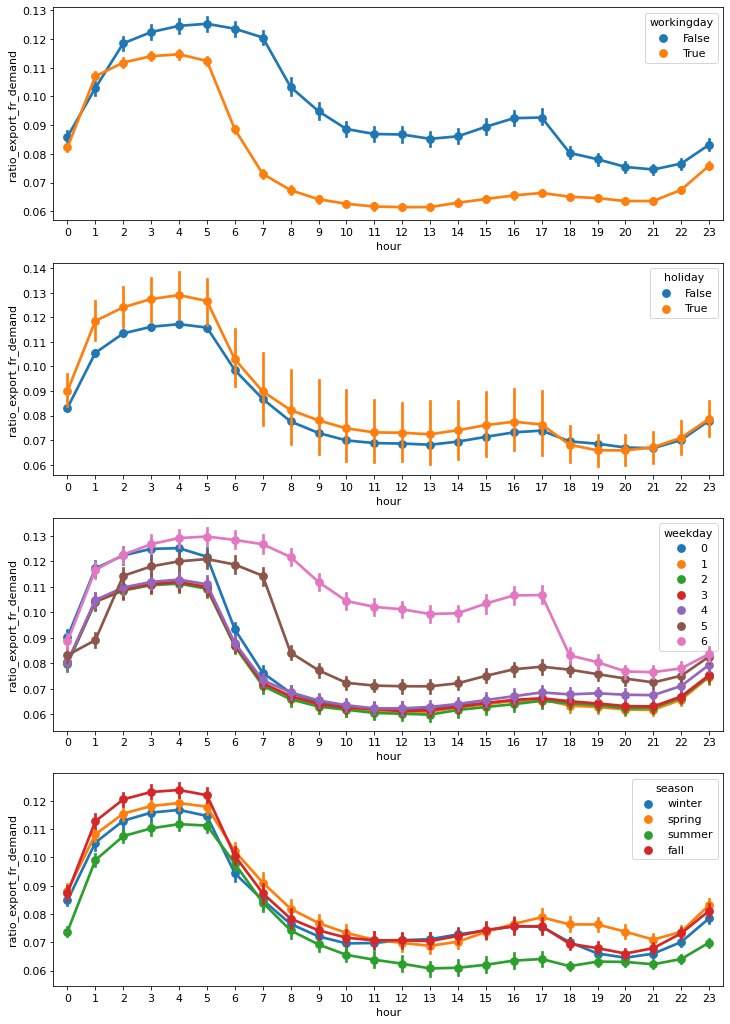

In [86]:
# Step 1 : Prepare m rows n columns Figure
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=4)
figure.set_size_inches(12, 18)

# Step 2 : Assign subplot
# Pointplot of the average demand per hours by workingday, holiday, weekday, season, weather
sns.pointplot(x='hour', y='ratio_export_fr_demand', data=df, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='ratio_export_fr_demand', data=df, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='ratio_export_fr_demand', data=df, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='ratio_export_fr_demand', data=df, hue='season', ax=axes[3])


To go more in depth with our analysis we decided to create some new variables sucha as the different ratios, we decided to start with ratio_export_FR_demand then we will continue with production and demand ratio.
Focusing on the ratio_export_FR_demand we can see that as we have previously seen for the first graph comparing the workingdays we agree that there is more ratio_export_FR_demand during the non working days this might be to the different consumptions theere are. We can also see that again on sundays are the days in which the ratio_export_FR_demand is the highest one, this again is due to the lower consumption of energy in this specific day, what is very interesting also is that we had previously seen that on saturdays there eas also less consumption but we can see here that for this ratio the line is more similar to the normal weekdays.

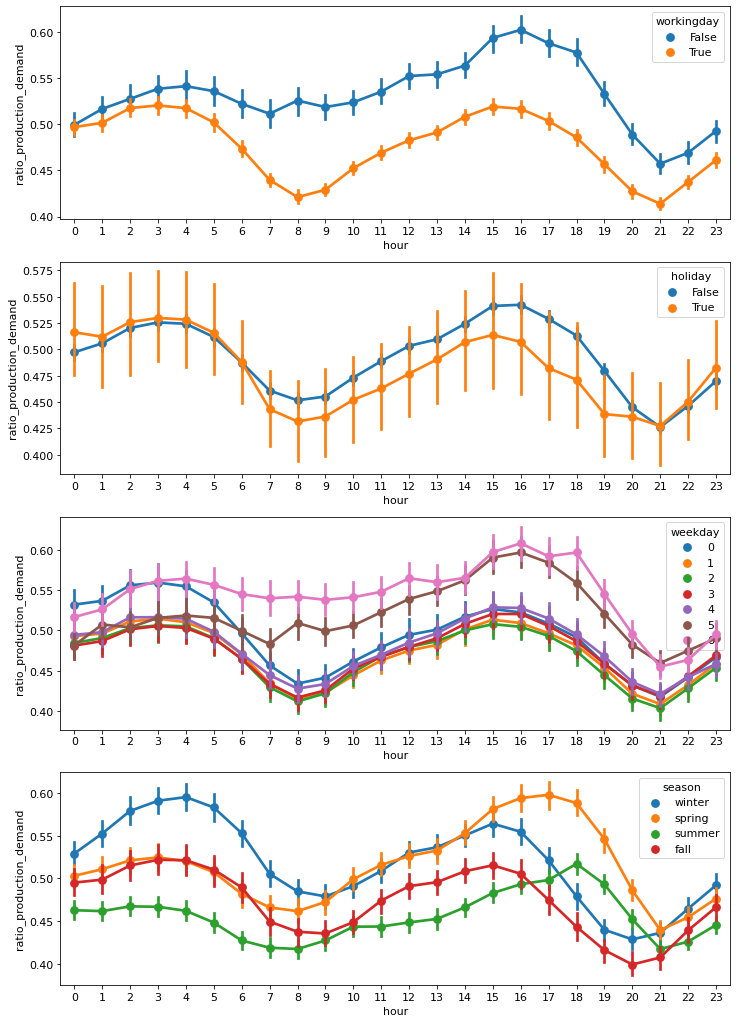

In [87]:
# Step 1 : Prepare m rows n columns Figure
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=4)
figure.set_size_inches(12, 18)

# Step 2 : Assign subplot
# Pointplot of the average demand per hours by workingday, holiday, weekday, season, weather
sns.pointplot(x='hour', y='ratio_production_demand', data=df, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='ratio_production_demand', data=df, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='ratio_production_demand', data=df, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='ratio_production_demand', data=df, hue='season', ax=axes[3])


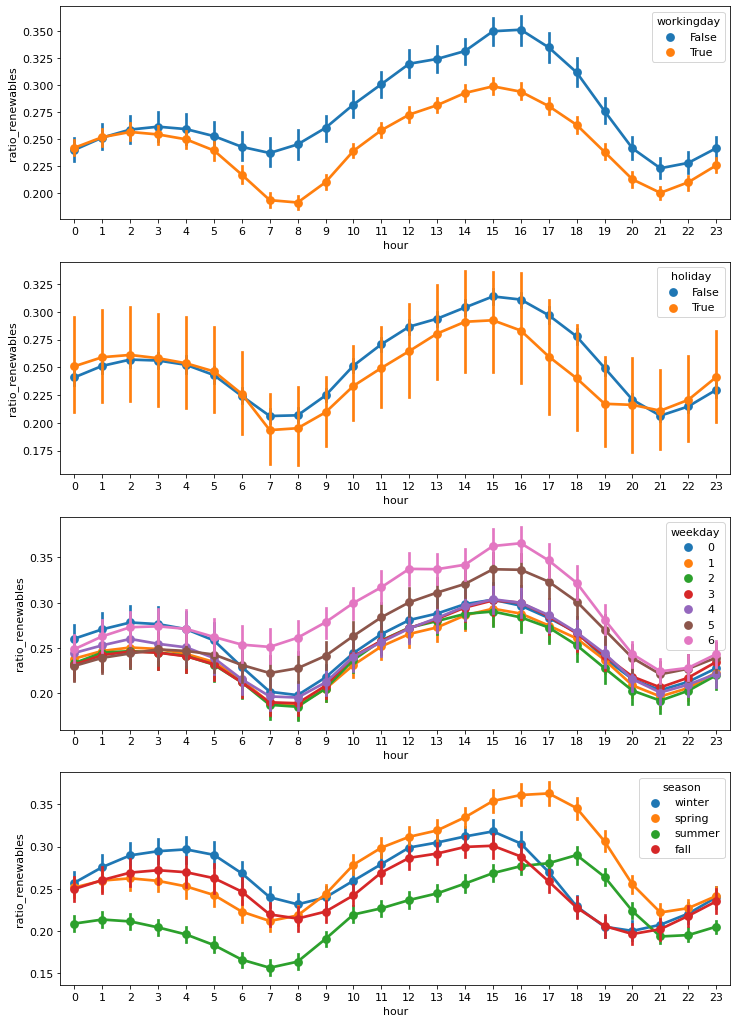

In [88]:
# Step 1 : Prepare m rows n columns Figure
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=4)
figure.set_size_inches(12, 18)

# Step 2 : Assign subplot
# Pointplot of the average demand per hours by workingday, holiday, weekday, season, weather
sns.pointplot(x='hour', y='ratio_renewables', data=df, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='ratio_renewables', data=df, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='ratio_renewables', data=df, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='ratio_renewables', data=df, hue='season', ax=axes[3])

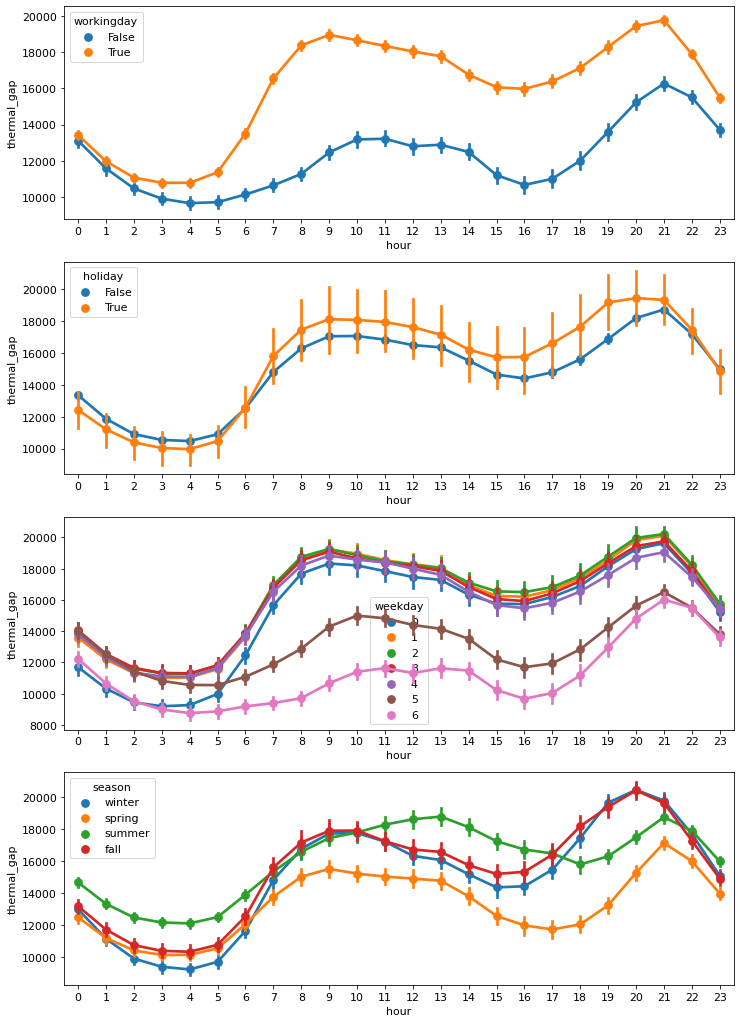

In [89]:
# Step 1 : Prepare m rows n columns Figure
plt.rc('font', size=11)
figure, axes = plt.subplots(nrows=4)
figure.set_size_inches(12, 18)

# Step 2 : Assign subplot
# Pointplot of the average demand per hours by workingday, holiday, weekday, season, weather
sns.pointplot(x='hour', y='thermal_gap', data=df, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='thermal_gap', data=df, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='thermal_gap', data=df, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='thermal_gap', data=df, hue='season', ax=axes[3])

### Correlation



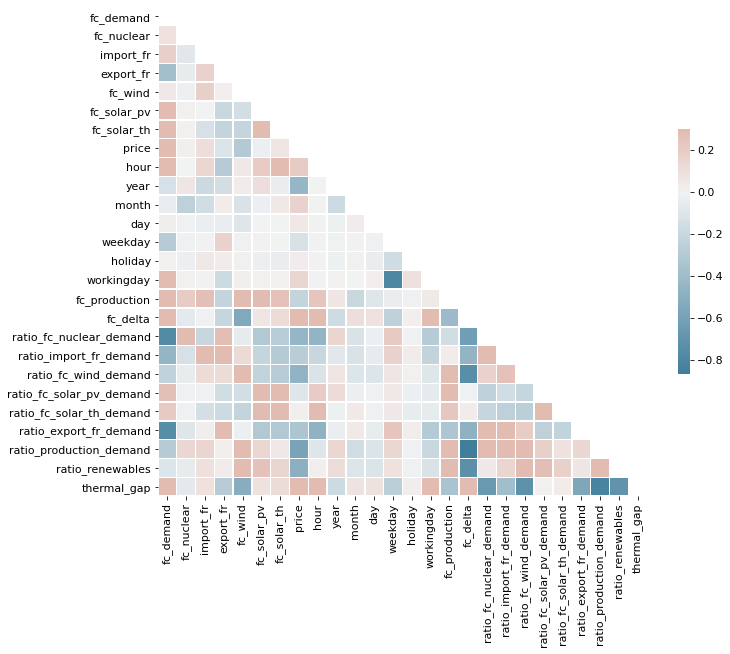

In [90]:
#  CORRELATION HEATMAP
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = False, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Modeling
The price being a continuous variable, to predict it we need the Regressor family models, such as Linear Regression, Random Forest Regression to predict.

As a start to build this model, we take only these facts into consideration:
1. Start with all the modifications done for EDA, remove variables gradually which would not contribute to define our model
2. The Regression models only work with numerical data.

For simplicity and to start our journey, we just take the dataframe as it was after modification and apply different algorithms to choose the best hyper-parameters.

In [91]:
energy=df.copy()
energy.tail()

,fc_demand,fc_nuclear,import_fr,export_fr,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour,year,month,day,weekday,season,holiday,workingday,fc_production,fc_delta,ratio_fc_nuclear_demand,ratio_import_fr_demand,ratio_fc_wind_demand,ratio_fc_solar_pv_demand,ratio_fc_solar_th_demand,ratio_export_fr_demand,ratio_production_demand,ratio_renewables,thermal_gap
32130,28832.0,7117.2,2200.0,1750.0,2846.0,2035.0,1615.4,47.88,2020-08-31,19,2020,8,31,0,summer,False,True,14063.6,14768.4,0.246851,0.076304,0.098710,0.070581,0.056028,0.060696,0.487777,0.225319,15218.4
32131,29453.0,7117.2,2200.0,1750.0,2861.0,325.8,1017.3,51.18,2020-08-31,20,2020,8,31,0,summer,False,True,11771.3,17681.7,0.241646,0.074695,0.097138,0.011062,0.034540,0.059417,0.399664,0.142739,18131.7
32132,30685.0,7117.2,2200.0,1750.0,2859.0,0.0,682.5,55.69,2020-08-31,21,2020,8,31,0,summer,False,True,11108.7,19576.3,0.231944,0.071696,0.093173,0.000000,0.022242,0.057031,0.362024,0.115415,20026.3
32133,28699.0,7117.2,2200.0,1750.0,2771.0,0.0,598.3,50.77,2020-08-31,22,2020,8,31,0,summer,False,True,10936.5,17762.5,0.247995,0.076658,0.096554,0.000000,0.020847,0.060978,0.381076,0.117401,18212.5
32134,26672.0,7117.2,2200.0,1750.0,2746.0,0.0,617.8,45.00,2020-08-31,23,2020,8,31,0,summer,False,True,10931.0,15741.0,0.266842,0.082484,0.102954,0.000000,0.023163,0.065612,0.409831,0.126117,16191.0


In [92]:
# Checking the datatypes, so that we do not use any datatypes, other than numericals
energy.dtypes

fc_demand                          float64
fc_nuclear                         float64
import_fr                          float64
export_fr                          float64
fc_wind                            float64
fc_solar_pv                        float64
fc_solar_th                        float64
price                              float64
date                        datetime64[ns]
hour                                 int64
year                                 int64
month                                int64
day                                  int64
weekday                              int64
season                              object
holiday                               bool
workingday                            bool
fc_production                      float64
fc_delta                           float64
ratio_fc_nuclear_demand            float64
ratio_import_fr_demand             float64
ratio_fc_wind_demand               float64
ratio_fc_solar_pv_demand           float64
ratio_fc_so

In [93]:
# Season being an object, has to be changed to categories, with numbers associated to each category
energy["season"]=energy["season"].astype('category').cat.codes

##### Train-Test Split

We split the data, based on the size of the scoring.csv dataset, we considered 5 months to be test dataset and the rest of the months as trained. We drop the date finally, as we used that attribute to divide our dataset, this dataset being time dependent.

In [94]:
def train_test_split(data, date_split):

    # training vs target
    x = data.drop(["price"], axis=1)
    y = data[["date","price"]]

    # splitting data
    x_train = x[x["date"] < date_split].drop("date", axis=1)
    x_test = x[x["date"] >= date_split].drop("date", axis=1)
    y_train = y[y["date"] < date_split].drop("date", axis=1).values.ravel()
    y_test = y[y["date"] >= date_split].drop("date", axis=1).values.ravel()

    print(f"x_train: {x_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    return x_train, x_test, y_train, y_test
# Split date set as 01-03-2020
date_split = pd.to_datetime("2020-03-01")
x_train, x_test, y_train, y_test = train_test_split(energy, date_split)

x_train: (25980, 26)
x_test: (3233, 26)
y_train: (25980,)
y_test: (3233,)


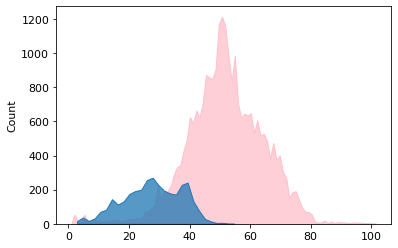

In [95]:
# Checking the Distribution in Train and Test Dataset
plt.rc('font', size=11)
figure.set_size_inches(12, 18)

sns.histplot(y_train,element="poly",color='pink')
sns.histplot(y_test,element="poly")

#### Helper Function
The below function is defined which will fit the train data on the model we choose, and calculate the predictions based on our test set. Also, prints out the RMSE Score for that model, Also looking at the residuals, even plotting a graph of its distributions to understand the concept of Heteroscedasticity.

In [96]:
def fit_predict(clf, x_train, y_train, x_test, y_test):
    
    # Step 2: Fit the train data
    clf.fit(x_train, y_train)    

    # Step 3 : Predict
    prediction = clf.predict(x_test)

    # Step 4 : Evaluate
    print('RMSE Value:',metrics.mean_squared_error(y_test, prediction, squared=False))
    # plot for residual error
 
    # setting plot style
    plt.style.use('fivethirtyeight')
    
    # plotting residual errors in test data
    plt.scatter(clf.predict(x_test), clf.predict(x_test) - y_test,
                color = "blue", s = 5, label = 'Test data')
     
    # plotting line for zero residual error
    plt.hlines(y = 0, xmin = -2, xmax = 60, linewidth = 2)
     
    # plotting legend
    plt.legend(loc = 'upper right')
     
    # plot title
    plt.title("Residual errors")
     
    # method call for showing the plot
    plt.show()
    
    # Show the distribution of errors
    sns.histplot((y_test-clf.predict(x_test)), bins = 50, kde=True)

#### Linear Regression
The type of Linear Regression we will be dealing with, is the Ordinary least squares Linear Regression, who main aim is to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

RMSE Value: 11.704357113372273


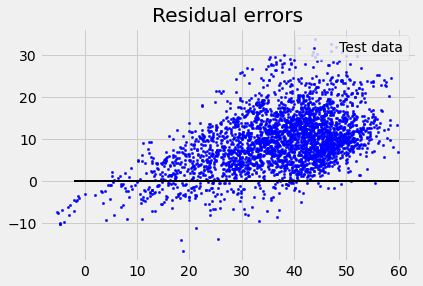

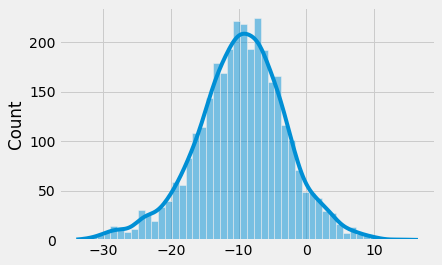

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# Step 1: Create Model
linear_reg_model = LinearRegression()

# Step 2: fit predict the model
fit_predict(linear_reg_model, x_train, y_train, x_test, y_test)


##### Conclusion
The model has an RMSE error of 11.70. Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; explaining how spread out these residuals are.

As mentioned previously, heteroskedasticity occurs when the variance for all observations in a data set are not the same. Conversely, when the variance for all observations are equal, we call that homoskedasticity. Why should we care about heteroskedasticity? Because it is a violation of the ordinary least square assumption that var(yi)=var(ei)=σ2

In the presence of heteroskedasticity, there are two main consequences on the least squares estimators:
1. The least squares estimator is still a linear and unbiased estimator, but with these current datat, it is no longer best. That is, there is another estimator with a smaller variance.
2. The standard errors computed for the least squares estimators are incorrect. This can affect confidence intervals and hypothesis testing that use those standard errors, which could lead to misleading conclusions.


#### Linear Regression Ridge

Our, first attempt, would be introducing the loss function in the linear least squares function and regularization is given by the L2 normalization. L2 regularization adds an L2 penalty, which equals the square of the magnitude of coefficients. All coefficients are shrunk by the same factor (so none are eliminated). It is given by the below formula:
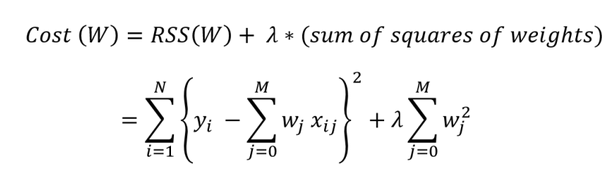

Best Parameter: {'alpha': 1000, 'max_iter': 3000}
RMSE Value: 13.441255492981908


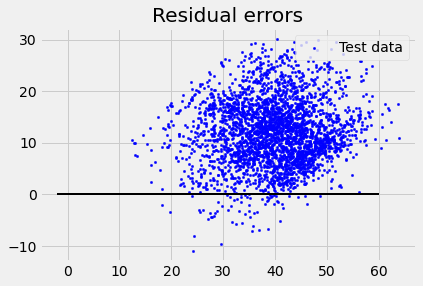

In [98]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Step 1: Create Model
ridge_model = Ridge()
# Step 2-1 : Create GridSearchCV Object
# Hyper-parameter List
ridge_params = {'max_iter':[3000], 'alpha':[0.5, 0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
# Evaluate Function for Cross-Validation (RMSE score)
rmse_scorer = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False) 

tscv = TimeSeriesSplit(n_splits=5)
# Create GridSearchCV Object (with Ridge)
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                      param_grid=ridge_params,
                                      scoring=rmse_scorer,
                                      cv=tscv)

# Step 2-2 : Perform Grid Search
gridsearch_ridge_model.fit(x_train, y_train) # Train (Grid Search)

print('Best Parameter:', gridsearch_ridge_model.best_params_)

# Step 3 : Predict
prediction = gridsearch_ridge_model.best_estimator_.predict(x_test)

# Step 4 : Evaluate
print('RMSE Value:',metrics.mean_squared_error(y_test, prediction,squared=False))

# plotting residual errors in test data
plt.scatter(gridsearch_ridge_model.best_estimator_.predict(x_test),\
            gridsearch_ridge_model.best_estimator_.predict(x_test) - y_test,
            color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = -2, xmax = 60, linewidth = 2)
 
# plotting legend
plt.legend(loc = 'upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()


In this case, the best option is to introduce a penalty of 1000, but the result are much worse than normal linear regression.

We are using GridSearchCV to get the best hyper-parameter, to stop the random selection of elements for validation set, we are using TimeSeriesSplit to select continuous data.

#### Random Forest Regressor

A random forest regressor is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting, decreasig variance and fixing the problem of overfitting.

Best Parameter: {'n_estimators': 10, 'random_state': 42}
RMSE Value: 9.024378646160251


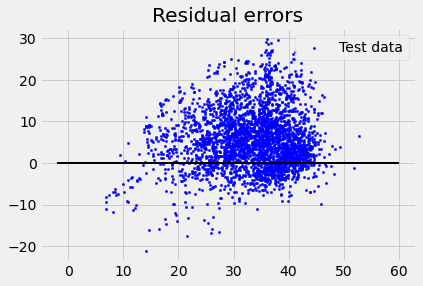

In [99]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Create Model
randomforest_model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
# Step 2-1 : Create GridSearchCV Object
# Hyper-parameter List
rf_params = {'random_state':[42], 'n_estimators':[5, 10, 50, 100]}
# Create GridSearchCV Object (with Random Forest Regression)
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmse_scorer,
                                              cv=tscv)

# Step 2-2 : Perform Grid Search
gridsearch_random_forest_model.fit(x_train, y_train)

print('Best Parameter:', gridsearch_random_forest_model.best_params_)

prediction = gridsearch_random_forest_model.best_estimator_.predict(x_test)

print('RMSE Value:',metrics.mean_squared_error(y_test, prediction,squared=False))

# plotting residual errors in test data
plt.scatter(gridsearch_random_forest_model.best_estimator_.predict(x_test),\
            gridsearch_random_forest_model.best_estimator_.predict(x_test) - y_test,
            color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = -2, xmax = 60, linewidth = 2)
 
# plotting legend
plt.legend(loc = 'upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

Till now, we have the least error in this model, with RMSE 9.02 having estimators as 50 which gave this RMSE error, now let us build a graph, with varying max_depth and see where the test error gets saturated.

max_depth: 1, err_train: 10.321, err_test=20.872
max_depth: 4, err_train: 7.579, err_test=10.572
max_depth: 7, err_train: 4.768, err_test=8.838
max_depth: 10, err_train: 3.212, err_test=8.825
max_depth: 13, err_train: 2.164, err_test=8.865
max_depth: 16, err_train: 1.474, err_test=8.845
max_depth: 19, err_train: 1.155, err_test=8.847
max_depth: 22, err_train: 1.056, err_test=8.862
max_depth: 25, err_train: 1.030, err_test=8.861
max_depth: 28, err_train: 1.027, err_test=8.866


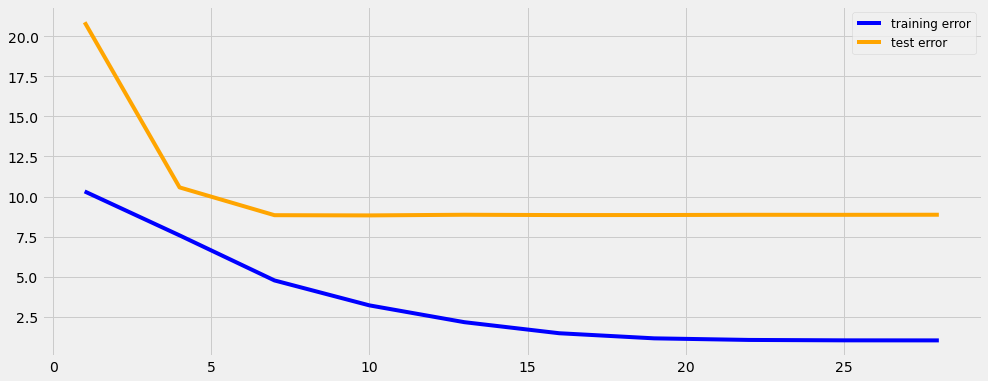

In [100]:
max_depth_range = range(1, 30, 3)
random_state=42

error_results = []

# looping through values of max_depth
for max_depth in max_depth_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": random_state,
        "n_estimators": 50
    }

    # train
    dt_2 = RandomForestRegressor(**parameters)
    dt_2.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_2.predict(x_train)  # prediction on the training set
    y_hat_test = dt_2.predict(x_test)  # prediction on the test set
    
    # evaluate
    err_train = metrics.mean_squared_error(y_train, y_hat_train,squared=False)  # accuracy achieved on the training data
    err_test  = metrics.mean_squared_error(y_test, y_hat_test,squared=False)  # accuracy achieved on the test data
    
    # store results
    error_results.append({
        "max_depth": max_depth, 
        "err_train": err_train,
        "err_test": err_test
    })
    
    # print evolution of loop:
    print(f"max_depth: {max_depth}, err_train: {err_train:.3f}, err_test={err_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["max_depth"], results["err_train"], label="training error", color="blue")
ax.plot(results["max_depth"], results["err_test"], label="test error", color="orange")
ax.legend(fontsize=12)

plt.show()

By the graph, the sweet spot where the test set error gets saturated is around 8. 

For train data also, we see a huge drop at the beginning, but goes on decreasing gradually.

#### Gradient Boosting Regressor

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees - which is the weak learner, building the model in a stage-wise fashion like other boosting methods do, to form one single strong learner in an iterative fashion.

Best Parameter: {'n_estimators': 10, 'random_state': 42}
RMSE Value: 16.933903713510436


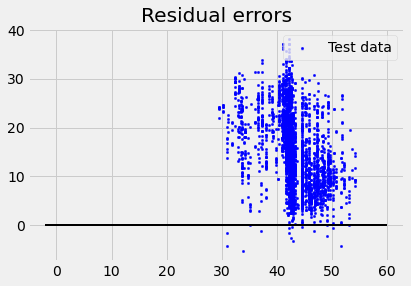

In [101]:
from sklearn.ensemble import GradientBoostingRegressor

# Step 1: Create Model
GradientBoosting_model = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits=5)
# Step 2-1 : Create GridSearchCV Object
# Hyper-parameter List
gbr_params = {'random_state':[42], 'n_estimators':[5, 10, 50]}
# Create GridSearchCV Object (with Random Forest Regression)
gridsearch_gradient_boosting_model = GridSearchCV(estimator=GradientBoosting_model,
                                              param_grid=gbr_params,
                                              scoring=rmse_scorer,
                                              cv=tscv)

# Step 2-2 : Perform Grid Search
gridsearch_gradient_boosting_model.fit(x_train, y_train)

print('Best Parameter:', gridsearch_gradient_boosting_model.best_params_)

prediction = gridsearch_gradient_boosting_model.best_estimator_.predict(x_test)

print('RMSE Value:',metrics.mean_squared_error(y_test, prediction,squared=False))

# plotting residual errors in test data
plt.scatter(gridsearch_gradient_boosting_model.best_estimator_.predict(x_test),\
            gridsearch_gradient_boosting_model.best_estimator_.predict(x_test) - y_test,
            color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = -2, xmax = 60, linewidth = 2)
 
# plotting legend
plt.legend(loc = 'upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

Till now, with this model, there is an increase in  RMSE 16.93 having estimators as  10 which gave this RMSE error. 

Now let us build a graph, with varying max_depth and see where the test error gets saturated

max_depth: 1, err_train: 10.396, err_test=22.113
max_depth: 4, err_train: 8.074, err_test=16.442
max_depth: 7, err_train: 6.122, err_test=14.499
max_depth: 10, err_train: 5.274, err_test=14.003
max_depth: 13, err_train: 4.794, err_test=14.315
max_depth: 16, err_train: 4.530, err_test=14.125
max_depth: 19, err_train: 4.425, err_test=14.380
max_depth: 22, err_train: 4.392, err_test=14.370
max_depth: 25, err_train: 4.383, err_test=14.373
max_depth: 28, err_train: 4.381, err_test=14.416


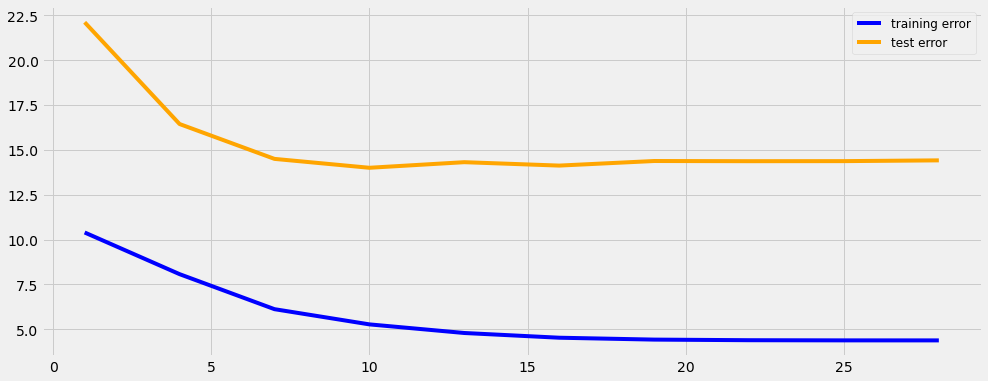

In [102]:
max_depth_range = range(1, 30, 3)
random_state=42

error_results = []

# looping through values of max_depth
for max_depth in max_depth_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": random_state,
        "n_estimators": 10
    }

    # train
    dt_2 = GradientBoostingRegressor(**parameters)
    dt_2.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_2.predict(x_train)  # prediction on the training set
    y_hat_test = dt_2.predict(x_test)  # prediction on the test set
    
    # evaluate
    err_train = metrics.mean_squared_error(y_train, y_hat_train,squared=False)  # accuracy achieved on the training data
    err_test  = metrics.mean_squared_error(y_test, y_hat_test,squared=False)  # accuracy achieved on the test data
    
    # store results
    error_results.append({
        "max_depth": max_depth, 
        "err_train": err_train,
        "err_test": err_test
    })
    
    # print evolution of loop:
    print(f"max_depth: {max_depth}, err_train: {err_train:.3f}, err_test={err_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["max_depth"], results["err_train"], label="training error", color="blue")
ax.plot(results["max_depth"], results["err_test"], label="test error", color="orange")
ax.legend(fontsize=12)

plt.show()

In this case we can find the minimum error at 10 for test set, after which the RMSE stabilized even when we increased the max_depth, but this model is providing us with worse error matrices and thus, in later steps we would not be focusing on this algorithm that much.

#### Support Vector Regression

An SVM model is basically a representation of different classes in a hyperplane in multidimensional space. The hyperplane will be generated in an iterative manner by SVM so that the error can be minimized. The goal of SVM is to divide the datasets into classes to find a maximum marginal hyperplane. The main parameter here being:

Kernel: A kernel helps us find a hyperplane in the higher dimensional space without increasing the computational cost. Usually, the computational cost will increase if the dimension of the data increases. This increase in dimension is required when we are unable to find a separating hyperplane in a given dimension and are required to move in a higher dimension.

We will be playing with this to build linear and non linear regression models

In [103]:
#from sklearn.svm import SVR
#
# Step 1: Create Model
#svr_model = SVR()
#
# Hyper-parameter List
#svr_params = {'kernel' : ('linear', 'rbf'),}
             #'C' : [1,5,10],
             #'gamma' : ('auto','scale')}
#tscv = TimeSeriesSplit(n_splits=3)       
# Step 2 : Create GridSearchCV Object
#gridsearch_svr_model = GridSearchCV(estimator=svr_model,
#                                              param_grid=svr_params,
#                                             scoring=rmse_scorer,
#                                              cv=tscv, n_jobs = -1, verbose = 2)

# Step 3 : Perform Grid Search
#gridsearch_svr_model.fit(x_train, y_train)

#print('Best Parameter:', gridsearch_svr_model.best_estimator_)

# Step 4 : Predict with the best parameter
#prediction = gridsearch_svr_model.best_estimator_.predict(x_test)

# Evaluate
#print('RMSE Value:',metrics.mean_squared_error(y_test, prediction,squared=False))

# plotting residual errors in test data
#plt.scatter(gridsearch_svr_model.best_estimator_.predict(x_test),\
            # gridsearch_svr_model.best_estimator_.predict(x_test) - y_test,
            # color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
#plt.hlines(y = 0, xmin = -2, xmax = 60, linewidth = 2)
 
# plotting legend
#plt.legend(loc = 'upper right')
 
# plot title
#plt.title("Residual errors")
 
# method call for showing the plot
#plt.show()

In [104]:
#C_range = range(1, 20, 5)
#random_state=42

#error_results = []

# looping through values of max_depth
#for C in C_range:
    
    # parameters
#    parameters = {
#        "C": C,
#        "random_state": random_state,
#        "kernel": 
#    }

    # train
#    dt_2 = SVR(**parameters)
#    dt_2.fit(x_train, y_train)
    
    # predict
#    y_hat_train = dt_2.predict(x_train)  # prediction on the training set
#    y_hat_test = dt_2.predict(x_test)  # prediction on the test set
    
#    # evaluate
#    err_train = metrics.mean_squared_error(y_train, y_hat_train,squared=False)  # accuracy achieved on the training data
#    err_test  = metrics.mean_squared_error(y_test, y_hat_test,squared=False)  # accuracy achieved on the test data
    
    # store results
#    error_results.append({
#        "max_depth": max_depth, 
#        "err_train": err_train,
#        "err_test": err_test
#    })
    
    # print evolution of loop:
#    print(f"max_depth: {max_depth}, err_train: {err_train:.3f}, err_test={err_test:.3f}")
    
# saving results as dataframe
#results = pd.DataFrame(error_results)

# plotting
#fig, ax = plt.subplots(figsize=(15, 6))

#ax.plot(results["max_depth"], results["err_train"], label="training error", color="blue")
#ax.plot(results["max_depth"], results["err_test"], label="test error", color="orange")
#ax.legend(fontsize=12)

#plt.show()

We commented out this part, beacuse we struggled to run this algorithm with our current resources. Please refer to the screenshot below:
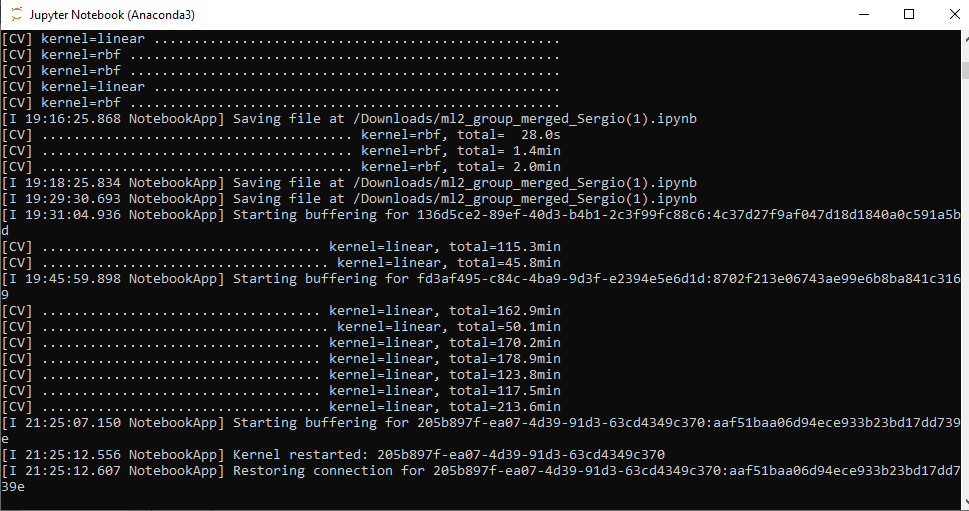

#### XGBRegressor

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. XGBoost improves upon the base GBM framework through systems optimization and algorithmic enhancements.
Optimization:
1. Parallelization: XGBoost approaches the process of sequential tree building using parallelized implementation. 
2. Tree Pruning: The stopping criterion for tree splitting within GBM framework is greedy in nature and depends on the negative loss criterion at the point of split. XGBoost uses ‘max_depth’ parameter as specified instead of criterion first, and starts pruning trees backward. This ‘depth-first’ approach improves computational performance significantly.
3. Regularization: It penalizes more complex models through both LASSO (L1) and Ridge (L2) regularization to prevent overfitting.
4. Cross-validation: The algorithm comes with built-in cross-validation method at each iteration, taking away the need to explicitly program this search and to specify the exact number of boosting iterations required in a single run.

[15:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

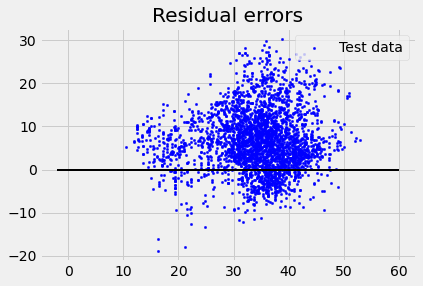

In [105]:
from xgboost import XGBRegressor

xgbr_model = XGBRegressor()
tscv = TimeSeriesSplit(n_splits=5)
# Step 2-1 : Create GridSearchCV Object
# Hyper-parameter List
xgbr_params = {'random_state':[42], 'n_estimators':[5, 10, 50]}
# Create GridSearchCV Object (with Random Forest Regression)
gridsearch_xgradient_boosting_model = GridSearchCV(estimator=xgbr_model,
                                              param_grid=xgbr_params,
                                              scoring=rmse_scorer,
                                              cv=tscv)

# Step 2-2 : Perform Grid Search
gridsearch_xgradient_boosting_model.fit(x_train, y_train)

print('Best Parameter:', gridsearch_xgradient_boosting_model.best_params_)

prediction = gridsearch_xgradient_boosting_model.best_estimator_.predict(x_test)

print('RMSE Value:',metrics.mean_squared_error(y_test, prediction,squared=False))

# plotting residual errors in test data
plt.scatter(gridsearch_xgradient_boosting_model.best_estimator_.predict(x_test),\
            gridsearch_xgradient_boosting_model.best_estimator_.predict(x_test) - y_test,
            color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = -2, xmax = 60, linewidth = 2)
 
# plotting legend
plt.legend(loc = 'upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

Till now, we have this model giving a low RMSE error in this model, with RMSE 9.52 having estimators as 10 which gave this RMSE error, now let us build a graph, with varying max_depth and see where the test error gets saturated.

[15:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
max_depth: 1, err_train: 20.660, err_test=7.883
[15:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
max_depth: 4, err_train: 19.603, err_test=8.022
[15:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
max_depth: 7, err_train: 18.943, err_test=8.989
[15:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
max_depth: 10, err_train: 18.803, err_test=9.160
[15:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
max_depth: 13, err_train: 18.777, err_test=9.217
[15:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederr

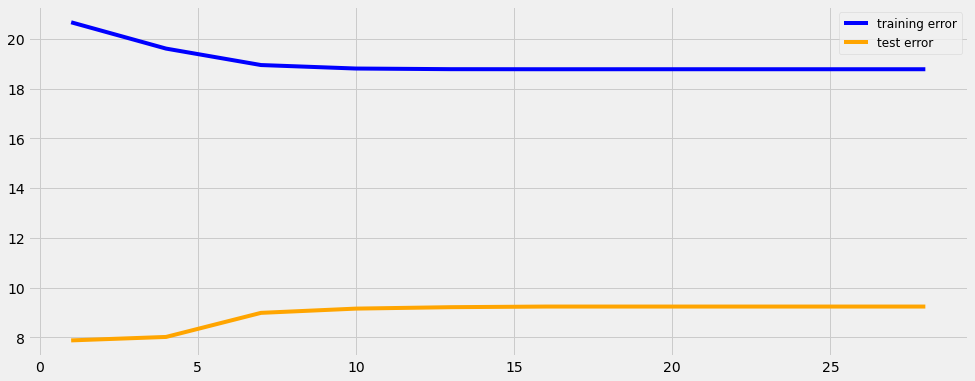

In [106]:
max_depth_range = range(1, 30, 3)
random_state=42

error_results = []

# looping through values of max_depth
for max_depth in max_depth_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": random_state,
        "n_estimators": 10
    }

    # train
    xgbr_1 = XGBRegressor(**parameters)
    xgbr_1.fit(x_train, y_train)
    
    # predict
    y_hat_train = xgbr_1.predict(x_train)  # prediction on the training set
    y_hat_test = xgbr_1.predict(x_test)  # prediction on the test set
    
    # evaluate
    err_train = metrics.mean_squared_error(y_train, y_hat_train,squared=False)  # accuracy achieved on the training data
    err_test  = metrics.mean_squared_error(y_test, y_hat_test,squared=False)  # accuracy achieved on the test data
    
    # store results
    error_results.append({
        "max_depth": max_depth, 
        "err_train": err_train,
        "err_test": err_test
    })
    
    # print evolution of loop:
    print(f"max_depth: {max_depth}, err_train: {err_train:.3f}, err_test={err_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["max_depth"], results["err_train"], label="training error", color="blue")
ax.plot(results["max_depth"], results["err_test"], label="test error", color="orange")
ax.legend(fontsize=12)

plt.show()

By the graph, the sweet spot where the test set error gets saturated is around 16. 

For train data also, we see a huge drop at the beginning, but goes on decreasing gradually.

#### Feature Importance
We will be selecting the important features according to the k highest scores. Two criterias are:
1. Information Gain: Mutual information for a continuous target.
2. F-Value: F-value between label/feature for regression tasks.

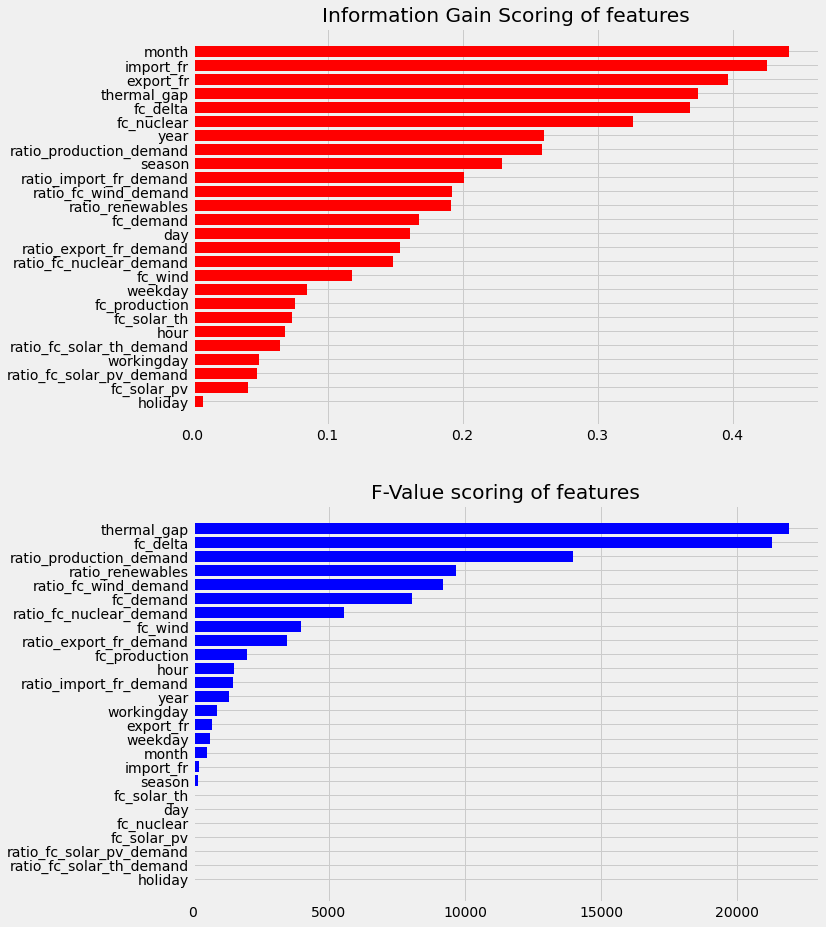

In [107]:
from sklearn.feature_selection import SelectKBest,mutual_info_regression, f_regression

# Select K best features according to the two different methods
ig_selector = SelectKBest(score_func=mutual_info_regression).fit(x_train,y_train)  # using Information Gain
fv_selector = SelectKBest(score_func=f_regression).fit(x_train,y_train)  # using F-Value

# Get the indices sorted by most important to least important
indices_ig = np.argsort(ig_selector.scores_)[::-1]
indices_fv = np.argsort(fv_selector.scores_)[::-1]

# Features and their score on each method
ig_features = []
for i in range(len(x_train.columns)):
    ig_features.append(x_train.columns[indices_ig[i]])
    
fv_features = []
for i in range(len(x_train.columns)):
    fv_features.append(x_train.columns[indices_fv[i]])
    
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Information Gain scores
axes[0].invert_yaxis()
axes[0].barh(ig_features, ig_selector.scores_[indices_ig[range(len(x_train.columns))]], color='r', align='center')
axes[0].set_title("Information Gain Scoring of features")

# F-Value scores
axes[1].invert_yaxis()
axes[1].barh(fv_features, fv_selector.scores_[indices_fv[range(len(x_train.columns))]], color='b', align='center')
axes[1].set_title("F-Value scoring of features")

plt.show()

In [108]:
regressor = LinearRegression()

methods = {
    "ig": ig_features,
    "fv": fv_features
}

comparison = []
for name, sorted_features in methods.items():
    features_used = 0
    for i, feature in enumerate(sorted_features):

        # training on a bigger subset of features as we loop through `chi2_features`
        # as i increases, a new feature is added to the training dataset
        # since the features were sorted in descending order of score, each added feature will add less value to our prediction
        x_train_subset = x_train[sorted_features[: i+1]]
        x_test_subset = x_test[sorted_features[: i+1]]

        # train
        regressor.fit(x_train_subset, y_train)

        # predict
        y_hat_subset = regressor.predict(x_test_subset)

        # calculate rmse
        rmse = metrics.mean_squared_error(y_test, y_hat_subset, squared=False)

        # increase counter to see how many features we have trained with
        features_used += 1
        dict_sorted = {
            "features": features_used,
            "rmse": rmse,
            "type": name
        }
        comparison.append(dict_sorted)
        
# put everything together in a dataframe
comparison_df = pd.DataFrame(comparison)

In [109]:
# Looking into the dataset where we store error for each attribute used
comparison_df.head(10)

,features,rmse,type
0,1,25.266853,ig
1,2,24.968077,ig
2,3,25.259704,ig
3,4,17.874193,ig
4,5,17.874193,ig
5,6,17.560220,ig
6,7,13.775041,ig
7,8,14.218341,ig
8,9,14.607686,ig
9,10,12.918122,ig


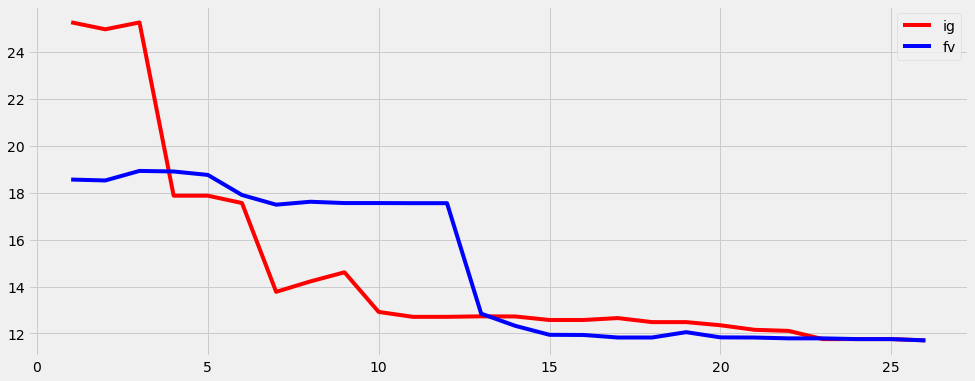

In [110]:
# Plot the rmse with addition of each attribute,
# both for Information Gain and F-Value
ig_evolution = comparison_df[comparison_df["type"]=="ig"]
fv_evolution = comparison_df[comparison_df["type"]=="fv"]

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(ig_evolution["features"], ig_evolution["rmse"], color="red", label="ig")
ax.plot(fv_evolution["features"], fv_evolution["rmse"], color="blue", label="fv")
ax.legend()

plt.show()

In [111]:
# Error got minimized at 15, thus we are selecting 15 top features
features_to_use = 15

# preparing subsets
x_train_ig = x_train[ig_features[:features_to_use]]
x_test_ig = x_test[ig_features[:features_to_use]]

x_train_fv = x_train[fv_features[:features_to_use]]
x_test_fv = x_test[fv_features[:features_to_use]]

RMSE Value: 9.042403115948321


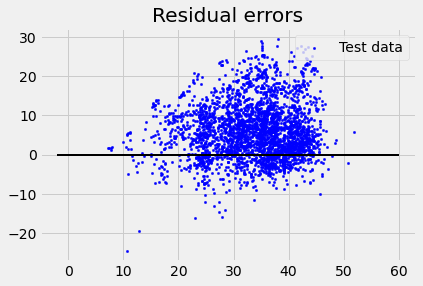

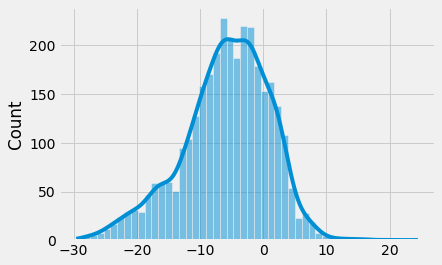

In [112]:
#taking top 15 attributes for Information gain
top15 = RandomForestRegressor(n_estimators=50,max_depth=10)
fit_predict(top15, x_train_ig, y_train, x_test_ig, y_test)


RMSE Value: 9.076937348260616


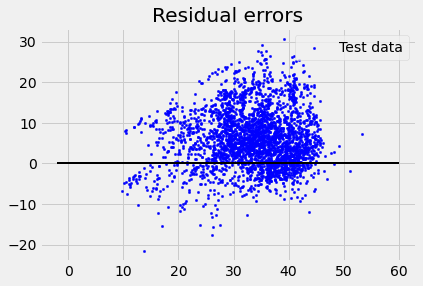

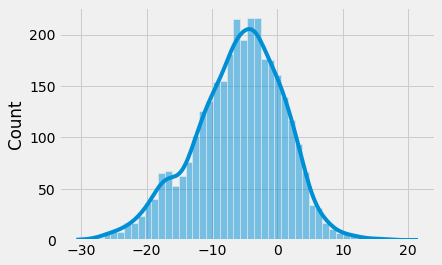

In [113]:
#taking top 15 attributes for F-Value
fit_predict(top15, x_train_fv, y_train, x_test_fv, y_test)

The feature importance of Information Gain provides us with a better model, when compared to a model, based on the F-value feature importance. For furthur models, we will be using the attributes mentioned by the information gain, in hope of finding a better model.

#### Column Transformer
Final engineering on the modelis done, like one hot encoder, and standard scaler on the values, to bring every thing to a same scale.

In [114]:
# Looking into the columns of Information Gain features
x_train_ig.columns

Index(['month', 'import_fr', 'export_fr', 'thermal_gap', 'fc_delta',
       'fc_nuclear', 'year', 'ratio_production_demand', 'season',
       'ratio_import_fr_demand', 'ratio_fc_wind_demand', 'ratio_renewables',
       'fc_demand', 'day', 'ratio_export_fr_demand'],
      dtype='object')

In [115]:
# Lets start with One Hot Encoding the date related attributes
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

preprocessing = ColumnTransformer([
                                   
    ("ohe",OneHotEncoder(sparse=False, handle_unknown='ignore'),["year","month","season"]),

],remainder='passthrough')

In [116]:
# Creating a pipeline to put preprocessing, Standard Scaling and Regression Model under one Umbrella
rf_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("Scaler",StandardScaler()),
    ("Regression", LinearRegression()),
])

RMSE Value: 7.20134874113791


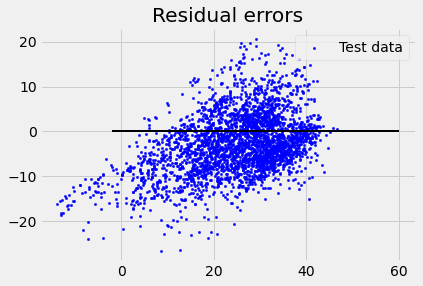

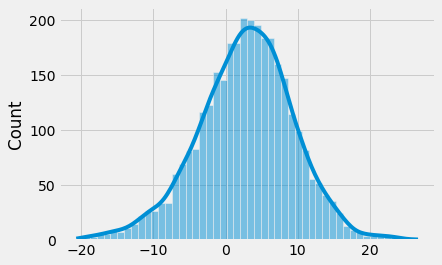

In [117]:
# Try fitting the model to Linear regression
fit_predict(rf_reg, x_train_ig, y_train, x_test_ig, y_test)

RMSE Value: 6.286682944652203


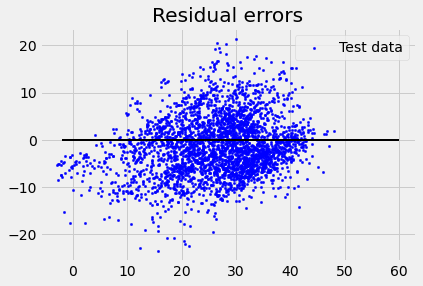

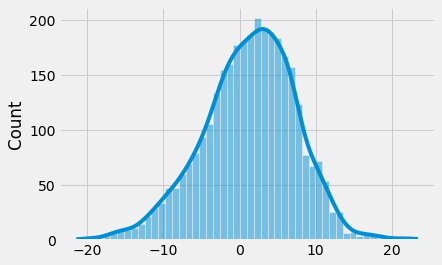

In [118]:
# Trying the preprocessing on Ridge with Penalty 1000
rf_reg.set_params(Regression=Ridge(alpha= 1000, max_iter=3000))
fit_predict(rf_reg, x_train_ig, y_train, x_test_ig, y_test)

Conclusion:

We got a better model, using the parameters used from the information gain feature importance, with a Ridge Model having an RMSE with as low as 6.38.

Let us look into the Scording.csv and predict the prices for the upcoming months.

### Predict the scoring.csv

We read the scoring.csv and use our last model to predict the prices.

In [119]:
scoring_df = pd.read_csv("scoring.csv", parse_dates=["date"])

scoring_df = scoring_df.rename(columns={"import_FR": "import_fr", "export_FR":"export_fr"})

In [120]:
# applying the same transformation as the training set
scoring_df=transform(scoring_df).dropna()
scoring_df.head()

,fc_demand,fc_nuclear,import_fr,export_fr,fc_wind,fc_solar_pv,fc_solar_th,date,hour,year,month,day,weekday,season,holiday,workingday,fc_production,fc_delta,ratio_fc_nuclear_demand,ratio_import_fr_demand,ratio_fc_wind_demand,ratio_fc_solar_pv_demand,ratio_fc_solar_th_demand,ratio_export_fr_demand,ratio_production_demand,ratio_renewables,thermal_gap
0,24744.0,7117.2,2300.0,1750.0,2751.0,0.0,627.1,2020-09-01,0,2020,9,1,1,summer,False,True,11045.3,13698.7,0.287633,0.092952,0.111178,0.0,0.025344,0.070724,0.446383,0.136522,14248.7
1,23426.0,7117.2,2300.0,2100.0,2452.0,0.0,606.6,2020-09-01,1,2020,9,1,1,summer,False,True,10375.8,13050.2,0.303816,0.098182,0.104670,0.0,0.025894,0.089644,0.442918,0.130564,13250.2
2,22597.0,7117.2,2300.0,2100.0,2060.0,0.0,528.3,2020-09-01,2,2020,9,1,1,summer,False,True,9905.5,12691.5,0.314962,0.101783,0.091163,0.0,0.023379,0.092933,0.438355,0.114542,12891.5
3,22285.0,7117.2,2300.0,2100.0,1736.0,0.0,598.5,2020-09-01,3,2020,9,1,1,summer,False,True,9651.7,12633.3,0.319372,0.103208,0.077900,0.0,0.026857,0.094234,0.433103,0.104757,12833.3
4,22192.0,7117.2,2300.0,2100.0,1322.0,0.0,474.9,2020-09-01,4,2020,9,1,1,summer,False,True,9114.1,13077.9,0.320710,0.103641,0.059571,0.0,0.021400,0.094629,0.410693,0.080971,13277.9


In [121]:
# Dropping the columns not present according to information gain
scoring_df=scoring_df.drop([ 'fc_wind','fc_solar_pv', 'fc_solar_th','hour',\
                  'weekday', 'holiday', 'workingday', 'fc_production','ratio_fc_nuclear_demand',\
                  'ratio_fc_solar_pv_demand','ratio_fc_solar_th_demand'],axis=1)

In [122]:
# rearranging the columns according to the training set
X_test_scoring=scoring_df.drop(['date'],axis=1)
X_test_scoring=X_test_scoring[['month', 'import_fr', 'export_fr', 'thermal_gap', 'fc_delta',\
       'fc_nuclear', 'year', 'ratio_production_demand', 'season',\
       'ratio_import_fr_demand', 'ratio_fc_wind_demand', 'ratio_renewables',\
       'fc_demand', 'day', 'ratio_export_fr_demand']]
X_test_scoring["season"]=X_test_scoring["season"].astype('category').cat.codes

In [123]:
# Step 3 : Predict the prices for the next 5 months
prediction = rf_reg.predict(X_test_scoring)
prediction = prediction.reshape(3673,1)

In [124]:
# Saving to CSV file
prediction = pd.DataFrame(prediction)
prediction.to_csv("y_pred_ridge_G.csv",header=["y_pred"])

In [125]:
# Trying prediction with XGBRegressor
rf_reg.set_params(Regression=XGBRegressor(n_estimators=10,max_depth=15))

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['year', 'month', 'season'])],
                                   verbose=False)),
                ('Scaler',
                 StandardScaler(copy=T...
                              colsample_bylevel=1, colsample_bynode=1,
  

In [127]:
# Predict values with X_test_scoring
rf_reg.fit(x_train_ig, y_train)
predict_xgb = rf_reg.predict(X_test_scoring)
predict_xgb = predict_xgb.reshape(3673,1)

[15:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [128]:
# Saving to CSV file
prediction = pd.DataFrame(predict_xgb)
prediction.to_csv("y_pred_xgb_G.csv",header=["y_pred"])